## Self-Learning Data Extraction and Auto Fine-Tuning System for Structured and Unstructured Datasets


**1. Unified Data Handling**
* Develop techniques to process and normalize structured (e.g., CSV, SQL, PDFs), unstructured (e.g., text, images), and streaming data from diverse sources.
* Enable seamless integration with offline files, legacy datasets, and live data pipelines (e.g., via data federation or APIs).


In [1]:
# all installs

!pip install pdfplumber
!pip install xlrd 
!pip install transformers>=4.21.0
!pip install torch
!pip install datasets
!pip install pytesseract Pillow 
!pip install matplotlib seaborn
!pip install shap
!pip install lime



!pip install peft
!pip install bitsandbytes
!pip install accelerate

In [2]:
# necesary libraries

# Fix protobufs:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python" 
os.environ["TRANSFORMERS_NO_SLOW_TOKENIZER"] = "1"

# Tesseract
try:
    import pytesseract
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
except ImportError:
    print("pytesseract not installed yet")


import pandas as pd
import pdfplumber
import sqlite3 
import requests
import time
import re
import torch, numpy, spacy
import json
import csv
import numpy as np

from difflib import SequenceMatcher 


import shutil

In [3]:
# Safety switches for Run All

SAFE_RUN = True       # Skip heavy/long steps (fine-tune) on first full run
INTERACTIVE = False   # Avoid input() prompts during Run All
print("SAFE_RUN =", SAFE_RUN, "| INTERACTIVE =", INTERACTIVE)


SAFE_RUN = True | INTERACTIVE = False


In [4]:
#  Simple type detection function 

# This function determines the file type based on the file extension

def detect_file_type(file_path):
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".csv":
        return "csv"
    elif ext == ".pdf":
        return "pdf"
    elif ext == ".txt":
        return "text"
    elif ext in [".xlsx", ".xls"]:  
        return "excel"
    elif ext == ".db": 
        return "sqlite"
    elif ext in [".png", ".jpg", ".jpeg", ".tiff", ".bmp"]: 
        return "image"
    else:
        return "unsupported"


In [5]:
# File loading functions for different data types 
# These functions handle the actual data extraction from supported file formats
# Each loader returns data in a standardized format for downstream processing

def load_csv(file_path):
    df = pd.read_csv(file_path)
    return df.to_dict(orient="records")  # returns list of row dictionaries

def load_pdf(file_path):
    data = []
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:
                data.append(text)
    return {"pages": data}

def load_excel(file_path):
    df = pd.read_excel(file_path)
    return df.to_dict(orient="records")

def load_sqlite(file_path, table_name):
    conn = sqlite3.connect(file_path)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df.to_dict(orient="records")

def load_text(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return {"text": f.read()}
    
def load_image_with_ocr(file_path):
    try:
        from PIL import Image
        import pytesseract
        
        # Set Tesseract path for Windows
        pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
        
        image = Image.open(file_path)
        # Enhanced OCR 
        text = pytesseract.image_to_string(
            image, 
            config='--oem 3 --psm 6 -l eng+deu'  # Multi-language support
        )
        return {"extracted_text": text.strip(), "source": "ocr"}
    
    except Exception as e:
        return {"error": f"OCR failed: {str(e)}", "extracted_text": ""}


def load_file(file_path):
    file_type = detect_file_type(file_path)
    if file_type == "csv":
        return load_csv(file_path)
    elif file_type == "pdf":
        return load_pdf(file_path)
    elif file_type == "text":
        return load_text(file_path)
    elif file_type == "excel":  
        return load_excel(file_path)  
    elif file_type == "sqlite": 
        return load_sqlite(file_path) 
    elif file_type == "image":
        return load_image_with_ocr(file_path)
    else: 
        raise ValueError(f"Unsupported file type: {file_type}")
    
    
    

In [6]:
# Testing text file

file_path = "example.txt"
data = load_file(r"C:\Users\aslia\OneDrive\Desktop\github\Predicting-Train-Delays\README.txt")
print(data)

{'text': '# Predicting Train Delays Using Deutsche Bahn (DB) Data\n\n## Overview\n\nThis project tackles the problem of predicting train arrival delays using \nhistorical data from Deutsche Bahn (DB), Germany\'s national railway. We approach the problem from two perspectives:\n\n- **Classification**: Will a train be delayed by more than 6 minutes?\n- **Regression**: How many minutes will a train be delayed?\n\nThe goal is to support better scheduling decisions, optimize passenger information systems, and demonstrate the effectiveness\nof supervised machine learning for real-world transportation challenges.\n\n\n## Project Structure\n\nPredicting-Train-Delays/\n├── README.md # Main project README (this file)\n├── requirements.txt # List of required Python packages\n├── DBtrainrides.csv # Dataset (to be downloaded)\n\n├── Classification/ # Classification task\n│ ├── ML_Final_Classification.ipynb\n│ └── README.md\n\n└── Regression/ # Regression task\n├── ML_Final_Regression.ipynb\n└── REA

In [7]:

def fetch_live_data(api_url, headers=None, timeout=10):
    try:
        response = requests.get(api_url, headers=headers, timeout=timeout)
        
        if response.status_code == 200:
            # Handle different content types
            content_type = response.headers.get('content-type', '')
            
            if 'json' in content_type:
                data = response.json()
            else:
                data = response.text
                
            return [{
                "file_name": f"api_data_{int(time.time())}",  # Unique timestamp
                "file_type": "json" if 'json' in content_type else "text",
                "source": "live_api",
                "content": [{
                    "section_id": 0,
                    "text": str(data),
                    "metadata": {
                        "source": api_url,
                        "timestamp": time.time(),
                        "status_code": response.status_code
                    }
                }]
            }]
        else:
            raise Exception(f"API returned status code: {response.status_code}")
            
    except requests.exceptions.RequestException as e:
        raise Exception(f"Failed to fetch live data: {str(e)}")

In [8]:
# Normalize the Extracted Content

# These functions convert extracted data into a standardized format for consistent processing
# All functions return a list of dictionaries with 'section_id', 'text', and 'metadata' fields
"""Detects file type cals the appropriate normalization function and
Returns unified document structure"""

def normalize_csv(file_path):  # Normalizes CSV data by converting each row into a standardized content block.
    df = pd.read_csv(file_path)
    content = []
    for idx, row in df.iterrows():
        content.append({ "section_id":idx, 
                        "text":str(row.to_dict()), "metadata": {"row": idx} # Convert row data to string representation
                        }
                       )
    return content

def normalize_pdf(file_path): # All functions return a list of dictionaries with 'section_id', 'text', and 'metadata' fields
    content = []
    with pdfplumber.open(file_path) as pdf:
        for i, page in enumerate(pdf.pages):
            text = page.extract_text()
            if text:   # Only include pages with extractable text
                content.append({
                    "section_id": i,
                    "text": text,
                    "metadata": {"page": i + 1}
                })
    return content

def normalize_text(file_path): # Normalizes text files by treating each non-empty line as a separate content section.
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    content = []
    for i, line in enumerate(lines):
        if line.strip():  # skip blank lines
            content.append({
                "section_id": i,
                "text": line.strip(),
                "metadata": {"line": i + 1}
            })
    return content

def normalize_excel(file_path): # Excel loader legacy dataset
    df = pd.read_excel(file_path)
    content = []
    for idx, row in df.iterrows():
        content.append({
            "section_id": idx,
            "text": str(row.to_dict()),
            "metadata": {"row": idx}
        })
    return content


# SQLite support  dataset

def normalize_sqlite(db_path, table_name):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    
    content = []
    for idx, row in df.iterrows():
        content.append({
            "section_id": idx,
            "text": str(row.to_dict()),
            "metadata": {"row": idx}
        })
    return content


# image normalization function

def normalize_image(file_path):
    ocr_result = load_image_with_ocr(file_path)
    
    if ocr_result.get("error"):
        return [{"section_id": 0, "text": "", "metadata": {"error": ocr_result["error"]}}]
    
    text = ocr_result["extracted_text"]
    if not text:
        return [{"section_id": 0, "text": "", "metadata": {"error": "No text found"}}]
    
    lines = text.split('\n')
    content = []
    
    for i, line in enumerate(lines):
        if line.strip():
            content.append({
                "section_id": i,
                "text": line.strip(),
                "metadata": {"line": i + 1, "source": "ocr"}
            })
    
    return content

In [9]:


# Master function that loads and normalizes any supported file type.

# Creates a unified data structure regardles of input file format.
    
def load_and_normalize(file_path, table_name=None):
    
    try:  # Check if file exists

        if not os.path.exists(file_path):
            raise FileNotFoundError (f"File not found: {file_path}")
    
        file_type = detect_file_type(file_path)
        file_name = os.path.basename(file_path) # Extract filename without path
        print(f"Processing {file_type} file: {file_name}")
        
# appropriatee normalization function based on file type

        if file_type == 'csv':
            content = normalize_csv(file_path)
        elif file_type == 'pdf':
            content = normalize_pdf(file_path)
        elif file_type == 'text':
            content = normalize_text(file_path)
        elif file_type == 'excel':
            content = normalize_excel(file_path)
        elif file_type == 'sqlite':
            if not table_name:
                raise ValueError("sqlite files required a table_name")
            content = normalize_sqlite(file_path, table_name)
        elif file_type == 'image': 
            content = normalize_image(file_path)
    
        elif file_type == 'unsupported':
            raise ValueError(f"Unsupported file type for: {file_name}")
    
        else:
            raise ValueError(f"Unsupported file type:{file_type}")
    
# Return standardized document structure                        
        return { 
                "file_name": file_name,
                "file_type": file_type,
                "source": "offline",
                "content": content,
                "processed_at": time.time() # Adds timestamp
            }
    except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            raise


In [10]:
# Testing

data = load_and_normalize(r"C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\Rechnung.pdf")
print(data)

Processing pdf file: Rechnung.pdf
{'file_name': 'Rechnung.pdf', 'file_type': 'pdf', 'source': 'offline', 'content': [{'section_id': 0, 'text': 'DEUBA GmbH & Co. KG | Zum Wiesenhof 84 | 66663 Merzig Rechnung\nNordson\nAhmed Ebada Datum 06.02.2020\nKapellenstr 12 Rechnungsnummer 1407606058\nKundenreferenz 1226475257\n85622 Feldkirchen\nKundennummer 21144538789\nLieferdatum 05.02.2020\nSeite 1 von 1\nPosBeschreibung Menge Preis Betrag\nEUR EUR\n1 191474 1 13,95 13,95\nMülleimer mit Schiebedeckel Kunststoff Silber 50 Liter\nVersandart: DPD\nGesamtnettowert (EUR) 11,72\nMehrwertsteuer 19,00% 2,23\nGesamtbruttowert (EUR) 13,95\nRechnungsdatum = Lieferdatum\nDiese Rechnung ist Bestandteil Ihres Auftrags vom 05.02.2020\nNur die in diesem Dokument als solche erkennbaren Produkte sind FSC zertifiziert.\nFSC Zertifizierungsnummer TSUD-COC-000791\nWir haben Ihre Zahlung am 05.02.2020 erhalten.\nZahlungsbedingung: ManoMano\nEs gelten unsere Ihnen bekannten Allgemeinen Geschäftsbedingungen.\nwww.deu

**2. Intelligent Information Extraction**
* Design or adapt machine learning and NLP models to automatically extract key entities, values, and patterns from heterogeneous data.
* Support document parsing, table recognition, entity linking, and contextual extraction.


In [11]:
# Adding missing imports

from typing import Dict, List, Optional
from datetime import datetime

from transformers import pipeline


In [12]:
# QABasedExtractor

from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

class QABasedExtractor:
    def __init__(self, model_name="deepset/xlm-roberta-large-squad2", local_dir="./lora_fine_tuned_model"):
        
        # Always define to avoid AttributeError
        self.ner_pipeline = None
        
        # Check for LoRA fine-tuned model
        if (os.path.isdir(local_dir) and 
            os.path.exists(os.path.join(local_dir, "adapter_config.json"))):
            
            print(f"Loading LoRA fine-tuned model from {local_dir}")
            
            # Load base model and tokenizer separately
            base_model = AutoModelForQuestionAnswering.from_pretrained(model_name)
            tokenizer = AutoTokenizer.from_pretrained(model_name)  # Use base model tokenizer
            
            # Load LoRA adapter
            model = PeftModel.from_pretrained(base_model, local_dir)
            
            # Create pipeline with both model and tokenizer
            self.qa_pipeline = pipeline(
                "question-answering",
                model=model,
                tokenizer=tokenizer,  # Explicitly provide tokenizer
                device=0 if torch.cuda.is_available() else -1
            )
            
        elif (os.path.isdir(local_dir) and 
              os.path.exists(os.path.join(local_dir, "config.json"))):
            
            print(f"Loading full fine-tuned model from {local_dir}")
            self.qa_pipeline = pipeline(
                "question-answering",
                model=local_dir,
                tokenizer=local_dir,
                device=0 if torch.cuda.is_available() else -1
            )
        else:
            print(f"Loading base model: {model_name}")
    
            # Load model and tokenizer explicitly
            base_model = AutoModelForQuestionAnswering.from_pretrained(model_name)
            tokenizer = AutoTokenizer.from_pretrained(model_name)

    
            # Create pipeline with both model and tokenizer
            self.qa_pipeline = pipeline(
                "question-answering",
                model=base_model,
                tokenizer=tokenizer,  # Explicitly provide tokenizer
                device=0 if torch.cuda.is_available() else -1
            )
        
        self.model_name = local_dir if os.path.isdir(local_dir) else model_name

        # Updated question templates with better targeting
        
        self.extraction_templates = {
            "invoice": [
                "What number appears after 'Invoice Number' or 'Rechnungsnummer'?",
                "What amount appears after 'Total' or 'Gesamtbetrag' or 'Endbetrag'?",
                "What company name appears at the top of the document?",
                "What date appears after 'Invoice Date' or 'Rechnungsdatum'?",
                "What is the largest monetary amount mentioned?",
                "What customer name appears on the invoice?",
                "What tax amount is mentioned?",
                "What is the net amount before tax?"
            ],
            "german_invoice": [
                "Welche Nummer steht nach 'Rechnungsnummer'?",
                "Welcher Betrag steht nach 'Gesamtbetrag' oder 'Endbetrag'?",
                "Wie heißt die Firma auf der Rechnung?",
                "Welches Datum steht nach 'Rechnungsdatum'?",
                "What number appears after 'Rechnungsnummer'?",
                "What amount appears after 'Gesamtbetrag' or 'Total'?",
                "What company name is mentioned?",
                "What date appears after 'Rechnungsdatum'?",
                "What is the highest amount in Euro mentioned?",
                "What is the MwSt or USt amount?",
                "What services or products are listed?",
                "What is the invoice number?",
                "What is the Rechnungsnummer?",
                "What is the total amount?",
                "What is the Gesamtbetrag?", 
                "What is the Endbetrag?",
                "What is the vendor name?",
                "What is the company name?",
                "What is the Firmenname?",
                "What is the invoice date?",
                "What is the Rechnungsdatum?",
                "What is the billing date?",
                "Who is the customer?",
                "What is the Kunde?",
                "What services were provided?",
                "What is the Leistung?",
                "What is the tax amount?",
                "What is the Mehrwertsteuer?",
                "What is the USt?",
                "What is the net amount?",
                "What is the Nettobetrag?"
            ],
            "general": [
                "What are the most important numbers in this document?",
                "What companies or organizations are mentioned?",
                "What dates are mentioned?",
                "What monetary amounts are mentioned?",
                "What are the key facts in this document?",
                "What is the main topic or subject of this document?",
                "What names of people are mentioned?",
                "What locations or addresses are mentioned?",
                "What email addresses or contact information is provided?",
                "What phone numbers are listed?",
                "What percentages or statistics are mentioned?",
                "What products or services are described?",
                "What deadlines or time periods are mentioned?",
                "What requirements or specifications are listed?",
                "What actions or tasks are described?",
                "What problems or issues are identified?",
                "What solutions or recommendations are provided?",
                "What project names or codes are mentioned?",
                "What versions or releases are referenced?",
                "What technologies or tools are discussed?",
                "What departments or teams are mentioned?",
                "What metrics or measurements are provided?",
                "What goals or objectives are stated?",
                "What risks or concerns are identified?",
                "What benefits or advantages are highlighted?"
            ]
        }
    
    def preprocess_text(self, text: str) -> str:
        """Enhanced preprocessing for invoices"""
        # basic cleaning
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        
        # invoice-specific preprocessing
        # context markers to help AI understand
        text = re.sub(r'(Rechnungsnummer|Invoice Number)[\s:]*([A-Z0-9\-]+)', 
                      r'The invoice number is \2. Rechnungsnummer: \2', text, flags=re.IGNORECASE)
        
        text = re.sub(r'(Gesamtbetrag|Total|Endbetrag)[\s:]*([€$]?\s*[\d,\.]+)', 
                      r'The total amount is \2. Gesamtbetrag: \2', text, flags=re.IGNORECASE)
        
        # limit length
        if len(text) > 2000:
            text = text[:2000] + "..."
        
        return text
    
    def extract_entities_with_ner(self, text: str) -> Dict:
        """Enhanced NER extraction"""
        ner = getattr(self, "ner_pipeline", None)
        if not ner:
            return {
                'organizations': [],
                'money': [],
                'dates': [],
                'persons': []
            }

        try:
            entities = ner(text)
            processed = {'organizations': [], 'money': [], 'dates': [], 'persons': []}
            for entity in entities:
                entity_type = entity.get('entity_group', '')
                word = entity.get('word', '').strip()
                if entity_type == 'ORG' and len(word) > 2:
                    processed['organizations'].append(word)
                elif entity_type == 'PER' and len(word) > 2:
                    processed['persons'].append(word)
            return processed
        except Exception:
            return {}
        
    def extract_with_questions(self, text: str, questions: List[str], 
                             confidence_threshold: float = 0.05) -> Dict:  # Lower threshold
        text = self.preprocess_text(text)
        results = {}
        
        for question in questions:
            try:
                qa_result = self.qa_pipeline(
                    question=question,
                    context=text,
                    max_answer_len=150  # Longer answers
                )
                
                results[question] = {
                    'answer': qa_result['answer'] if qa_result['score'] >= confidence_threshold else None,
                    'confidence': qa_result['score'],
                    'start_pos': qa_result.get('start', 0),
                    'end_pos': qa_result.get('end', 0),
                    'extracted': qa_result['score'] >= confidence_threshold
                }
                
            except Exception as e:
                results[question] = {
                    'answer': None,
                    'confidence': 0.0,
                    'error': str(e),
                    'extracted': False
                }
        
        return results
    
    def auto_detect_document_type(self, text: str) -> str:
        text_lower = text.lower()
        
        # Better German detection
        german_keywords = ['rechnung', 'rechnungsnummer', 'mehrwertsteuer', 'ust', 'gesamtbetrag', 'firmenname']
        if any(keyword in text_lower for keyword in german_keywords):
            return 'german_invoice'
        
        # English invoice detection
        if any(word in text_lower for word in ['invoice', 'bill to', 'invoice number']):
            return 'invoice'
        
        return 'general'
    
    def extract_information(self, text: str, document_type: Optional[str] = None, 
                          custom_questions: Optional[List[str]] = None) -> Dict:
        
        # Autodetect if not provided
        if document_type is None:
            document_type = self.auto_detect_document_type(text)
        
        # Choose questions
        if custom_questions:
            questions = custom_questions
        else:
            questions = self.extraction_templates.get(document_type, self.extraction_templates['general'])
        
        # Extract with QA
        qa_results = self.extract_with_questions(text, questions)
        
        # Extract entities with NER if available
        ner_results = self.extract_entities_with_ner(text)
        
        # Combine results
        successful = sum(1 for r in qa_results.values() if r.get('extracted'))
        
        return {
            'document_type': document_type,
            'extraction_timestamp': datetime.now().isoformat(),
            'model_used': self.model_name,
            'total_questions': len(questions),
            'successful_extractions': successful,
            'success_rate': successful / len(questions) if questions else 0,
            'extractions': qa_results,
            'entities': ner_results
        }
        
    # Only uses high-confidence predictions for further training
    # This prevents error propagation
    def get_high_confidence_extractions(self, results: Dict, min_confidence: float = 0.3) -> Dict:
        """Lower confidence threshold for invoice extraction"""
        high_conf = {}
        
        for question, result in results['extractions'].items():
            if result.get('confidence', 0) >= min_confidence and result.get('answer'):
                high_conf[question] = result
        
        return {
            'document_type': results['document_type'],
            'high_confidence_extractions': high_conf,
            'total_high_confidence': len(high_conf)
        }

In [13]:
# Enhanced data processing pipeline with QA extraction

def process_document_with_qa(document_data: Dict, custom_questions: Optional[List[str]] = None) -> Dict:
    """
    Process a normalized document using QA-based extraction.
    """
    extractor = QABasedExtractor()
    
    # Combine all text content from the document
    all_text = ""
    for content_item in document_data['content']:
        all_text += content_item['text'] + " "
    
    """Takes your normalized document (which has text split by pages/sections)
Combines everything into one big text string
This gives the AI the full context to answer questions"""

    # Extract information using QA
    extraction_results = extractor.extract_information(
        text=all_text,
        custom_questions=custom_questions
    )
    """Passes the combined text to your AI extractor
Uses custom questions if provided (like your German questions)
Gets back structured answers with confidence scores"""

    # extraction results to document data
    
    document_data['qa_extraction'] = extraction_results
    document_data['high_confidence_extractions'] = extractor.get_high_confidence_extractions(
        extraction_results
    )
    """Adds AI results to  original document structure
Creates two versions: all results + high-confidence only
Preserves original data while adding AI insights"""
    
    return document_data

In [14]:
# Integration with existing pipeline
def enhanced_load_and_normalize_with_qa(file_path: str, table_name: Optional[str] = None, 
                                       custom_questions: Optional[List[str]] = None) -> Dict:
    """
    Enhanced version of load_and_normalize that includes QA extraction.
    """
    # Use existing normalization function
    document_data = load_and_normalize(file_path, table_name)
    
    # QA-based extraction
    enhanced_data = process_document_with_qa(document_data, custom_questions)
    """Takes the normalized document
Runs AI question-answering
Adds intelligent extraction results
Returns enhanced document with AI insights"""
    return enhanced_data


In [15]:
# Auto-trigger fine-tuning when enough new feedback exists
try:
    if not SAFE_RUN:
        print("Checking if fine-tuning should run from feedback...")
        maybe_finetune(threshold_new_rows=5)
        print("Done.")
    else:
        print("SAFE_RUN=True: skipping fine-tune auto-trigger")
except NameError:
    print("Skipping auto-trigger: maybe_finetune not defined yet.")

SAFE_RUN=True: skipping fine-tune auto-trigger


In [16]:
# Testing with German PDF
german_path = r"C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\Rechnung.pdf"

# Load and process
result = enhanced_load_and_normalize_with_qa(german_path)

# Show improved results
print(f"✅ Document: {result['file_name']}")
print(f"✅ Type: {result['qa_extraction']['document_type']}")
print(f"✅ Success Rate: {result['qa_extraction']['success_rate']:.1%}")
print(f"✅ Extractions: {result['qa_extraction']['successful_extractions']}/{result['qa_extraction']['total_questions']}")

print("\n=== High Confidence Results ===")
for question, answer in result['high_confidence_extractions']['high_confidence_extractions'].items():
    print(f"Q: {question}")
    print(f"A: {answer['answer']} (confidence: {answer['confidence']:.3f})")
    print("-" * 40)

# Show NER entities if found
if result['qa_extraction'].get('entities'):
    print("\n=== Named Entities Found ===")
    for entity_type, entities in result['qa_extraction']['entities'].items():
        if entities:
            print(f"{entity_type}: {entities}")

Processing pdf file: Rechnung.pdf
Loading base model: deepset/xlm-roberta-large-squad2


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ Document: Rechnung.pdf
✅ Type: german_invoice
✅ Success Rate: 61.3%
✅ Extractions: 19/31

=== High Confidence Results ===
Q: Wie heißt die Firma auf der Rechnung?
A:  Nordson Ahmed Ebada (confidence: 0.906)
----------------------------------------
Q: Welches Datum steht nach 'Rechnungsdatum'?
A:  Lieferdatum (confidence: 0.929)
----------------------------------------
Q: What date appears after 'Rechnungsdatum'?
A:  Lieferdatum (confidence: 0.865)
----------------------------------------
Q: What is the invoice number?
A:  1407606058. (confidence: 0.561)
----------------------------------------
Q: What is the Rechnungsnummer?
A:  1407606058. (confidence: 0.308)
----------------------------------------
Q: What is the total amount?
A:  Gesamtbruttowert (EUR) 13,95 (confidence: 0.375)
----------------------------------------
Q: What is the Rechnungsdatum?
A:  Lieferdatum (confidence: 0.678)
----------------------------------------
Q: Who is the customer?
A:  Nordson Ahmed Ebada (confiden

In [17]:
# Quick test of  multi-format system (extra .txt file)

print("Testing Multi-Format Document Extraction")

test_files = [
    r"C:\Users\aslia\OneDrive\Desktop\github\Predicting-Train-Delays\README.txt"]


for file_path in test_files:
    if os.path.exists(file_path):
        print(f"\n Testing: {os.path.basename(file_path)}")
        try:
            result = enhanced_load_and_normalize_with_qa(file_path)
            print(f"✅ Type: {result['qa_extraction']['document_type']}")
            print(f"✅ Success Rate: {result['qa_extraction']['success_rate']:.1%}")
            
            # Show top 3 extractions
            count = 0
            for question, answer in result['qa_extraction']['extractions'].items():
                if answer.get('answer') and count < 3:
                    print(f"   Q: {question[:50]}...")
                    print(f"   A: {answer['answer']}")
                    count += 1
                    
        except Exception as e:
            print(f"❌ Error: {e}")
    else:
        print(f" File not found: {file_path}")

Testing Multi-Format Document Extraction

 Testing: README.txt
Processing text file: README.txt
Loading base model: deepset/xlm-roberta-large-squad2


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ Type: general
✅ Success Rate: 28.0%
   Q: What companies or organizations are mentioned?...
   A:  Deutsche Bahn
   Q: What requirements or specifications are listed?...
   A:  Python packages
   Q: What actions or tasks are described?...
   A:  Classification task


In [18]:
# Testing with OCR + QA system

print("=== Testing OCR Integration with YOUR System ===")

# Test image path
image_path = r"C:\Users\aslia\Downloads\invoice_sample.png"

if os.path.exists(image_path):
    
    # Use  existing pipeline
    result = enhanced_load_and_normalize_with_qa(image_path)
    
    print(f"✅ OCR + QA Success!")
    print(f"✅ Document: {result['file_name']}")
    print(f"✅ Type: {result['qa_extraction']['document_type']}")
    print(f"✅ AI Extractions: {result['qa_extraction']['successful_extractions']}")
    
    # Show results using system
    for question, answer in result['high_confidence_extractions']['high_confidence_extractions'].items():
        print(f"Q: {question}")
        print(f"A: {answer['answer']} (confidence: {answer['confidence']:.3f})")
        print("-" * 40)
else:
    print("Add your image path to test")

=== Testing OCR Integration with YOUR System ===
Processing image file: invoice_sample.png
Loading base model: deepset/xlm-roberta-large-squad2


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ OCR + QA Success!
✅ Document: invoice_sample.png
✅ Type: invoice
✅ AI Extractions: 2
Q: What customer name appears on the invoice?
A:  Richard Sanchez (confidence: 0.980)
----------------------------------------


**3. Self-Learning and Auto Fine-Tuning**
* Build a feedback loop that captures user corrections, validation mismatches, or annotation logs.
* Implement automatic model fine-tuning or retraining using this feedback without manual intervention.
* Ensure continuous performance improvement while avoiding overfitting.



In [19]:
# Phase 3A: Feedback Collection

from pathlib import Path


# Path to store feedback logs
feedback_file = Path("feedback_log.csv")

# Create file with headers if it doesn't exist

if not feedback_file.exists():
    with open(feedback_file, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "question", "context", "predicted_answer", "correct_answer"])

# Captures human feedback for reinforcement
def log_feedback(question, context, predicted_answer, correct_answer=None):
    """
    Logs model output and user-provided corrections to a CSV file.
    """
    with open(feedback_file, mode="a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            datetime.now().isoformat(),
            question,
            context,
            predicted_answer,
            correct_answer if correct_answer else ""
        ])

# Example usage after prediction step:

question = "What is the capital of Germany?"
context = "Berlin is the capital and largest city of Germany."
predicted_answer = "Berlin"

# Suppose user confirms or corrects:

if INTERACTIVE:
    correct_answer = input(f"Predicted answer: {predicted_answer}\nIf wrong, type correct answer (or press Enter to confirm): ")
else:
    print("INTERACTIVE=False: auto-confirming predicted answer")
    correct_answer = predicted_answer

print("Feedback logged.")

INTERACTIVE=False: auto-confirming predicted answer
Feedback logged.


🔹feedback_log.csv is created the first time you run it. After each prediction, the system:
   Shows the predicted answer.
   Lets the user correct it or press Enter to confirm.

Appends a new row with timestamp, Q, context, prediction, and correction.

🔹This creates your personal dataset for fine-tuning.
 It ensures the model improves based on your domain-specific corrections.

In [20]:
# Phase 3B: Prepare Feedback for Fine-Tuning

# Load feedback
feedback_file = "feedback_log.csv"

# Prepare SQuAD-style dataset(current model deepset/xlm-roberta-large-squad2 uses this format)
data = {
    "version": "v2.0",
    "data": [
        {
            "title": "feedback_data",
            "paragraphs": []
        }
    ]
}

import hashlib 
with open(feedback_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        context = row["context"]
        question = row["question"]
        answer_text = row["correct_answer"] or row["predicted_answer"]

        # Find start index of answer in context (required for SQuAD format)
        start_index = context.find(answer_text)
        if start_index == -1:
            continue  # skip if answer not found in context

        # Force string types and stable ID
        safe_q = str(question)
        safe_ctx = str(context)
        qid = hashlib.sha1((safe_q + "||" + safe_ctx).encode("utf-8")).hexdigest()

        paragraph = {
            "context": safe_ctx,
            "qas": [
                {
                    "id": qid,
                    "question": safe_q,
                    "answers": [
                        {
                            "text": answer_text,
                            "answer_start": start_index
                        }
                    ],
                    "is_impossible": False
                }
            ]
        }
        data["data"][0]["paragraphs"].append(paragraph)

# Save dataset
with open("feedback_dataset.json", "w", encoding="utf-8") as out_file:
    json.dump(data, out_file, ensure_ascii=False, indent=2)
print("feedback_dataset.json created!")

feedback_dataset.json created!


* Read feedback_log.csv ( manually collected corrections).

* Convert it to SQuAD-style JSON : required for most extractive QA fine-tuning (current model deepset/xlm-roberta-large-squad2 uses this format).

* Save it as feedback_dataset.json.

In [21]:
# Create sample data if feedback_log.csv is empty
import csv
from datetime import datetime

if not os.path.exists("feedback_log.csv") or os.path.getsize("feedback_log.csv") <= 100:
    print("Creating sample feedback data...")
    
    with open("feedback_log.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "question", "context", "predicted_answer", "correct_answer"])
        
        # Add sample entries
        samples = [
            [datetime.now().isoformat(), "What is the invoice number?", "Invoice RE-001 Total: 1000 EUR", "RE-001", "RE-001"],
            [datetime.now().isoformat(), "What is the total amount?", "Invoice RE-001 Total: 1000 EUR", "1000 EUR", "1000 EUR"],
            [datetime.now().isoformat(), "What is the company name?", "ACME Corp Invoice RE-001", "ACME Corp", "ACME Corp"]
        ]
        
        for sample in samples:
            writer.writerow(sample)
    
    print("✅ Sample feedback data created!")

In [22]:
# Phase 3C:load the feedback_dataset.json into a Hugging Face Dataset object.

if os.path.exists("feedback_dataset.json"):
    with open("feedback_dataset.json", encoding="utf-8") as f:
        data = json.load(f)
    print(f"feedback_dataset.json loaded: {len(data['data'][0]['paragraphs'])} paragraphs")
else:
    print("feedback_dataset.json not found")

feedback_dataset.json loaded: 3 paragraphs


In [23]:
# Phase 3D: Fine-tuning with LoRA

import os, json, torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForQuestionAnswering,
    TrainingArguments, Trainer, DefaultDataCollator
)
from peft import LoraConfig, get_peft_model, TaskType

os.environ["TOKENIZERS_PARALLELISM"] = "false"
model_name = "deepset/xlm-roberta-large-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load your SQuAD-style feedback JSON

with open("feedback_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

examples = []
for article in data["data"]:
    for para in article["paragraphs"]:
        ctx = para["context"]
        for qa in para["qas"]:
            ans = qa["answers"][0] if qa.get("answers") else {"text": "", "answer_start": 0}
            examples.append({
                "question": qa["question"],
                "context": ctx,
                "answer_text": ans.get("text", ""),
                "answer_start": ans.get("answer_start", 0),
            })

def make_features(ex):
    tok = tokenizer(
        ex["question"],
        ex["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offsets = tok.pop("offset_mapping")
    seq_ids = tok.sequence_ids()

    # Context token span
    start_ctx = 0
    while start_ctx < len(seq_ids) and seq_ids[start_ctx] != 1:
        start_ctx += 1
    end_ctx = len(seq_ids) - 1
    while end_ctx >= 0 and seq_ids[end_ctx] != 1:
        end_ctx -= 1

    start_char = ex["answer_start"]
    end_char = start_char + len(ex["answer_text"])

    if ex["answer_text"] == "":
        start_pos = end_pos = start_ctx
    elif not (offsets[start_ctx][0] <= start_char and offsets[end_ctx][1] >= end_char):
        start_pos = end_pos = start_ctx
    else:
        s = start_ctx
        while s < len(offsets) and offsets[s][0] <= start_char:
            s += 1
        start_pos = s - 1
        e = end_ctx
        while e > 0 and offsets[e][1] >= end_char:
            e -= 1
        end_pos = e + 1

    tok["start_positions"] = start_pos
    tok["end_positions"] = end_pos
    return tok

class QADataset(Dataset):
    def __init__(self, examples):
        self.features = [make_features(ex) for ex in examples]
    def __len__(self):
        return len(self.features)
    def __getitem__(self, i):
        return {k: torch.tensor(v) for k, v in self.features[i].items()}

train_dataset = QADataset(examples)
print(f"Train samples: {len(train_dataset)}")

#base model
model = AutoModelForQuestionAnswering.from_pretrained(model_name)


# LoRA Configuration 
lora_config = LoraConfig(
    task_type=TaskType.QUESTION_ANS,
    inference_mode=False,
    r=16,  # Rank - higher = more parameters but slower
    lora_alpha=32,  # Scaling parameter
    lora_dropout=0.1,  # Dropout for LoRA layers
    target_modules=["query", "value"]  # Which layers to adapt
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  

# training arguments for LoRA
args = TrainingArguments(
    output_dir="./lora_fine_tuned_model",
    eval_strategy="no",
    learning_rate=3e-4, 
    per_device_train_batch_size=4,  # Can use larger batch
    num_train_epochs=2,  # Fewer epochs needed
    weight_decay=0.01,
    logging_steps=5,
    save_total_limit=1,
    push_to_hub=False,
    report_to=None,
    dataloader_pin_memory=False,
    save_strategy="epoch",
    warmup_steps=10,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    data_collator=DefaultDataCollator(),
)

print(" Starting LoRA fine-tuning")
trainer.train()
trainer.save_model("./lora_fine_tuned_model")
tokenizer.save_pretrained("./lora_fine_tuned_model")
print("✅ LoRA fine-tuning complete! Saved to './lora_fine_tuned_model'")



Train samples: 3


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The 8-bit optimizer is not available on your device, only available on CUDA for now.


trainable params: 1,574,914 || all params: 560,417,796 || trainable%: 0.2810
 Starting LoRA fine-tuning


Step,Training Loss


✅ LoRA fine-tuning complete! Saved to './lora_fine_tuned_model'


In [24]:
# Phase 3E:Automatic fine-tuning 

# This is the "self-learning" part that makes this system continuously improve without human intervention
# heart of the self-learning system

from peft import PeftModel, LoraConfig, get_peft_model, TaskType
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForQuestionAnswering,
    TrainingArguments, Trainer, DefaultDataCollator
)

#1.  File Management Setup
"""Defines paths for state tracking, feedback storage, and model output
STATE_FILE: Tracks training history (.self_tune_state.json)
FEEDBACK_CSV: User corrections (feedback_log.csv)
FEEDBACK_JSON: Training-ready format (feedback_dataset.json)"""

STATE_FILE = Path(".self_tune_state.json") # Tracks training history
FEEDBACK_CSV = Path("feedback_log.csv")  # User corrections
FEEDBACK_JSON = Path("feedback_dataset.json") # Training-ready format
OUTPUT_DIR = Path("./lora_fine_tuned_model") # Where improved model is saved

BASE_MODEL = "deepset/xlm-roberta-large-squad2"


#2. State Tracking Functions
"""_load_state() and _save_state(): Remember how many feedback rows were used for training
_feedback_count(): Count new user corrections since last training
Prevents retraining on the same data repeatedly"""

def _load_state(): # + save?state Remember how many feedback rows were used for training
    if STATE_FILE.exists():
        return json.loads(STATE_FILE.read_text(encoding="utf-8"))
    return {"last_trained_count": 0, "last_trained_at": 0}

def _save_state(state):
    STATE_FILE.write_text(json.dumps(state, indent=2), encoding="utf-8")

def _feedback_count():   # Count new user corrections since last training
    if not FEEDBACK_CSV.exists():
        return 0
    with FEEDBACK_CSV.open(newline="", encoding="utf-8") as f:
        reader = csv.reader(f)
        rows = list(reader)
        return max(0, len(rows) - 1)  # minus header

#3. Data Conversion Pipeline
"""_build_squad_from_csv(): Converts user feedback CSV into SQuAD format (the training format AI models expect)
_load_examples(): Loads and prepares training examples
_features_maker(): Tokenizes questions/contexts and maps answer positions"""

def _build_squad_from_csv(csv_path=FEEDBACK_CSV, out_json=FEEDBACK_JSON): #cnverts feedbacks CSV into SQuAD format (the training format AI models expect)
    if not csv_path.exists():
        raise FileNotFoundError("feedback_log.csv not found")
    import hashlib 
    data = {"version": "v2.0", "data": [{"title": "feedback_data", "paragraphs": []}]}
    with csv_path.open(newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            ctx = row["context"]
            q = row["question"]
            ans_text = row["correct_answer"] or row["predicted_answer"]
            start = ctx.find(ans_text)
            if start == -1:
                continue
            safe_q = str(q)
            safe_ctx = str(ctx)
            qid = hashlib.sha1((safe_q + "||" + safe_ctx).encode("utf-8")).hexdigest()
            data["data"][0]["paragraphs"].append({
                "context": safe_ctx,
                "qas": [{
                    "id": qid,
                    "question": safe_q,
                    "answers": [{"text": ans_text, "answer_start": start}],
                    "is_impossible": False
                }]
            })
    out_json.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")
    return out_json


def _load_examples(feedback_json=FEEDBACK_JSON):
    d = json.loads(Path(feedback_json).read_text(encoding="utf-8"))
    examples = []
    for article in d["data"]:
        for para in article["paragraphs"]:
            ctx = para["context"]
            for qa in para["qas"]:
                ans = qa["answers"][0] if qa.get("answers") else {"text": "", "answer_start": 0}
                examples.append({
                    "question": qa["question"],
                    "context": ctx,
                    "answer_text": ans.get("text", ""),
                    "answer_start": ans.get("answer_start", 0),
                })
    return examples



def _features_maker(tokenizer): 
    def make_features(ex):
        tok = tokenizer(
            ex["question"], ex["context"],
            truncation="only_second", max_length=384, stride=128,
            return_offsets_mapping=True, padding="max_length",
        )
        offsets = tok.pop("offset_mapping")
        seq_ids = tok.sequence_ids()
        start_ctx = 0
        while start_ctx < len(seq_ids) and seq_ids[start_ctx] != 1:
            start_ctx += 1
        end_ctx = len(seq_ids) - 1
        while end_ctx >= 0 and seq_ids[end_ctx] != 1:
            end_ctx -= 1
        start_char = ex["answer_start"]
        end_char = start_char + len(ex["answer_text"])
        if ex["answer_text"] == "":
            start_pos = end_pos = start_ctx
        elif not (offsets[start_ctx][0] <= start_char and offsets[end_ctx][1] >= end_char):
            start_pos = end_pos = start_ctx
        else:
            s = start_ctx
            while s < len(offsets) and offsets[s][0] <= start_char:
                s += 1
            start_pos = s - 1
            e = end_ctx
            while e > 0 and offsets[e][1] >= end_char:
                e -= 1
            end_pos = e + 1
        tok["start_positions"] = start_pos
        tok["end_positions"] = end_pos
        return tok
    return make_features

class QADataset(Dataset):
    def __init__(self, examples, tokenizer):
        maker = _features_maker(tokenizer)
        self.features = [maker(ex) for ex in examples]
    def __len__(self): return len(self.features)
    def __getitem__(self, i): return {k: torch.tensor(v) for k, v in self.features[i].items()}



#4. LoRA Fine-Tuning Functions
# train_from_feedback function

"""train_from_feedback_lora(): The actual fast LoRA fine-tuning process
QADataset: PyTorch dataset class for training
Much faster than full fine-tuning"""

def train_from_feedback_lora(base_model=None, output_dir="./lora_fine_tuned_model", epochs=2, lr=3e-4, batch_size=4):
    """Fast LoRA fine-tuning from feedback"""
    from peft import LoraConfig, get_peft_model, TaskType
    
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    base = base_model or BASE_MODEL
    
    _build_squad_from_csv(FEEDBACK_CSV, FEEDBACK_JSON)
    examples = _load_examples(FEEDBACK_JSON)
    
    if not examples:
        print("No examples to train.")
        return False

    tokenizer = AutoTokenizer.from_pretrained(base)
    dataset = QADataset(examples, tokenizer)
    print(f" LoRA training samples: {len(dataset)} (base={base})")

    # Load base model
    model = AutoModelForQuestionAnswering.from_pretrained(base)
    
    # Apply LoRA
    lora_config = LoraConfig(
        task_type=TaskType.QUESTION_ANS,
        inference_mode=False,
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=["query", "value"]
    )
    
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    
    args = TrainingArguments(
        output_dir=str(output_dir),
        eval_strategy="no",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=5,
        save_total_limit=1,
        push_to_hub=False,
        report_to=None,
        dataloader_pin_memory=False,
        warmup_steps=10,
    )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset,
        data_collator=DefaultDataCollator(),
    )
    
    print(" Starting fast LoRA training...")
    trainer.train()
    trainer.save_model(str(output_dir))
    tokenizer.save_pretrained(str(output_dir))
    print(f"✅ LoRA model saved to {output_dir}")
    return True



# 5. Auto-Trigger automatically retrains when enough feedback collected actuaşl "self-training" part


"""maybe_finetune_lora(): The "smart automation" that checks if enough new feedback exists
Default threshold: 5 new corrections trigger automatic retraining
Updates state tracking after successful training"""

def maybe_finetune_lora(threshold_new_rows=5):
    """Auto-trigger LoRA fine-tuning"""
    state = _load_state()
    total = _feedback_count()
    new = total - state.get("last_trained_count", 0)
    print(f"Feedback rows: {total} (new since last train: {new})")
    if new >= threshold_new_rows:
        print(" Starting fast LoRA fine-tuning...")
        ok = train_from_feedback_lora()  # Much faster!
        if ok:
            state["last_trained_count"] = total
            state["last_trained_at"] = int(time.time())
            _save_state(state)
            print("✅ LoRA fine-tuned and state updated.")
    else:
        print(f"Not enough new feedback yet (need {threshold_new_rows}).")
        
        """How It Works in Practice:
You use the system → AI makes predictions
You correct wrong answers → Logged to feedback_log.csv
Background check → maybe_finetune() counts new corrections
Auto-training → When you have 5+ new corrections, it automatically fine-tunes
Improved model → Next time you use the system, it's smarter
Why This Is Powerful:
Zero manual work: No need to manually retrain
Continuous improvement: Gets better with each correction you make
Domain-specific: Learns YOUR specific documents and terminology
Memory: Never forgets previous corrections"""

**4.	Model Evaluation and Versioning**
* Define evaluation metrics for accuracy, confidence, and error detection.
* Track model versions and performance history, and allow safe promotion of improved models.

In [ ]:
# Step 4A Model Evaluation and Versioning System

class ModelEvaluator:
    def __init__(self, metrics_file="model_metrics.json"):
        # Creates a tracker that saves results to a JSON file
        self.metrics_file = Path(metrics_file)
        self.metrics_history = self._load_metrics() # Loads previous results
        
    def _load_metrics(self):
        if self.metrics_file.exists():
            return json.loads(self.metrics_file.read_text())
        return {"evaluations": []}
    
    def _save_metrics(self):
        self.metrics_file.write_text(json.dumps(self.metrics_history, indent=2))
    
    def create_ground_truth_template(self, invoice_files): # invoice_files is a LIST of paths
        """Create template for manual ground truth annotation""" 
        template = {}
        for file_path in invoice_files:
            filename = Path(file_path).name  # Extract just filename (eg "invoice1.pdf")
            template[filename] = {
                "invoice_number": "",
                "total_amount": "",
                "company_name": "",
                "invoice_date": "",
                "tax_amount": "",
                "net_amount": "",
                "customer_name": "",
                "notes": "Manual annotation needed"
            }
        
        # Save template
        with open("ground_truth_template.json", "w") as f:
            json.dump(template, f, indent=2)
        
        print("Ground truth template created: ground_truth_template.json")
        print("Please fill in the correct values manually")
        return template
    
    def evaluate_extraction_results(self, results_dict, ground_truth=None, document_name=""):
        """Evaluate extraction quality with multiple metrics"""
        evaluation = {
            "timestamp": datetime.now().isoformat(),
            "document_name": document_name,
            "model_version": results_dict.get('qa_extraction', {}).get('model_used', 'unknown'),
            "document_type": results_dict.get('qa_extraction', {}).get('document_type', 'unknown'),
            "total_questions": results_dict.get('qa_extraction', {}).get('total_questions', 0),
            "successful_extractions": results_dict.get('qa_extraction', {}).get('successful_extractions', 0),
            "success_rate": results_dict.get('qa_extraction', {}).get('success_rate', 0),
            "avg_confidence": self._calculate_avg_confidence(results_dict),
            "high_confidence_count": len(results_dict.get('high_confidence_extractions', {}).get('high_confidence_extractions', {}))
        } 
        
        # Add ground truth comparison if available
        if ground_truth:
            evaluation.update(self._compare_with_ground_truth(results_dict, ground_truth))
        
        self.metrics_history["evaluations"].append(evaluation)
        self._save_metrics()
        return evaluation
    
    def _calculate_avg_confidence(self, results_dict):
        extractions = results_dict.get('qa_extraction', {}).get('extractions', {})
        confidences = [result.get('confidence', 0) for result in extractions.values() 
                      if result.get('confidence') is not None]
        return sum(confidences) / len(confidences) if confidences else 0
    
    def _compare_with_ground_truth(self, results_dict, ground_truth):
        """Compare extractions with ground truth for accuracy metrics"""
        extractions = results_dict.get('qa_extraction', {}).get('extractions', {})
        
        # Key extraction mapping
        key_mappings = {
            "invoice_number": ["rechnungsnummer", "invoice number", "nummer"],
            "total_amount": ["gesamtbetrag", "total", "endbetrag", "amount"],
            "company_name": ["company", "firma", "firmenname", "vendor"],
            "invoice_date": ["datum", "date", "rechnungsdatum"],
            "tax_amount": ["mwst", "ust", "tax", "mehrwertsteuer"],
            "net_amount": ["netto", "net", "nettobetrag"]
        }
        
        correct = 0
        total = 0
        detailed_results = {}
        
        for gt_key, gt_value in ground_truth.items():
            if not gt_value:  # Skip empty ground truth values
                continue
                
            best_match = None
            best_similarity = 0
            
            # Find best matching extraction
            for question, result in extractions.items():
                if result.get('answer') and any(keyword in question.lower() for keyword in key_mappings.get(gt_key, [])):
                    similarity = self._answers_match_score(result['answer'], gt_value)
                    if similarity > best_similarity:
                        best_similarity = similarity
                        best_match = result['answer']
            
            total += 1
            is_correct = best_similarity >= 0.8
            if is_correct:
                correct += 1
            
            detailed_results[gt_key] = {
                "ground_truth": gt_value,
                "predicted": best_match,
                "similarity": best_similarity,
                "correct": is_correct
            }
        
        accuracy = correct / total if total > 0 else 0
        return {
            "ground_truth_accuracy": accuracy,
            "correct_answers": correct,
            "total_compared": total,
            "detailed_results": detailed_results
        }
    
    def _answers_match_score(self, predicted, actual):
        """Calculate similarity score between predicted and actual answers"""
        if not predicted or not actual:
            return 0
        
        # Clean and normalize
        pred_clean = str(predicted).lower().strip()
        actual_clean = str(actual).lower().strip()
        
        # Exact match
        if pred_clean == actual_clean:
            return 1.0
        
        # Fuzzy matching
        similarity = SequenceMatcher(None, pred_clean, actual_clean).ratio()
        
        # Bonus for number matching (important for invoices)
    
        pred_numbers = re.findall(r'\d+[\.,]?\d*', pred_clean)
        actual_numbers = re.findall(r'\d+[\.,]?\d*', actual_clean)
        
        if pred_numbers and actual_numbers:
            # Normalize numbers for comparison
            pred_num = pred_numbers[0].replace(',', '.')
            actual_num = actual_numbers[0].replace(',', '.')
            try:
                if float(pred_num) == float(actual_num):
                    similarity = max(similarity, 0.9)
            except:
                pass
        
        return similarity
    
    def batch_evaluate_invoices(self, invoice_folder, ground_truth_file=None):
        """ Runs your AI on multiple invoices to generates performance report."""
        invoice_folder = Path(invoice_folder)
        results = []
        
        # Load ground truth
        ground_truth_data = {}
        if ground_truth_file and Path(ground_truth_file).exists():
            with open(ground_truth_file) as f:
                ground_truth_data = json.load(f)
        
        # Process each file type separately to fix the glob() error
        supported_patterns = ["*.pdf", "*.png", "*.jpg", "*.jpeg", "*.tiff", "*.bmp"]
        
        for pattern in supported_patterns:
            for invoice_file in invoice_folder.glob(pattern):  # ONE pattern at a time
                print(f"Processing: {invoice_file.name}")
                
                try:
                    # Extract using your existing pipeline
                    result = enhanced_load_and_normalize_with_qa(str(invoice_file))
                    
                    # Get ground truth for this file
                    gt = ground_truth_data.get(invoice_file.name, {})
                    
                    # Evaluate
                    evaluation = self.evaluate_extraction_results(result, gt, invoice_file.name)
                    results.append(evaluation)
                    
                    print(f"✅ Success rate: {evaluation['success_rate']:.1%}")
                    if gt:
                        print(f"✅ Accuracy: {evaluation.get('ground_truth_accuracy', 0):.1%}")
                    
                except Exception as e:
                    print(f"❌ Error processing {invoice_file.name}: {e}")
        
        # Generate summary report
        if results:
            self._generate_evaluation_report(results)
        else:
            print("❌ No files were processed successfully!")
            print(" Check if files exist in:", str(invoice_folder.absolute()))
            
        return results
    
    def _generate_evaluation_report(self, results):
        """Generate comprehensive evaluation report"""
        if not results:
            print("No results to report")
            return
        
        df = pd.DataFrame(results)
        
        report = f"""
=== INVOICE EXTRACTION EVALUATION REPORT ===
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

    OVERALL PERFORMANCE:
• Total invoices processed: {len(results)}
• Average success rate: {df['success_rate'].mean():.1%}
• Average confidence: {df['avg_confidence'].mean():.3f}
• High confidence extractions: {df['high_confidence_count'].mean():.1f}/question

    ACCURACY METRICS:
"""
        
        if 'ground_truth_accuracy' in df.columns:
            accuracy_data = df.dropna(subset=['ground_truth_accuracy'])
            if not accuracy_data.empty:
                report += f"""• Ground truth accuracy: {accuracy_data['ground_truth_accuracy'].mean():.1%}
• Correct answers: {accuracy_data['correct_answers'].sum()}/{accuracy_data['total_compared'].sum()}
• Best performing invoice: {accuracy_data.loc[accuracy_data['ground_truth_accuracy'].idxmax(), 'document_name']}
• Worst performing invoice: {accuracy_data.loc[accuracy_data['ground_truth_accuracy'].idxmin(), 'document_name']}
"""
        
        report += f"""
 PERFORMANCE DISTRIBUTION:
• Success rate std dev: {df['success_rate'].std():.3f}
• Confidence std dev: {df['avg_confidence'].std():.3f}

    RECOMMENDATIONS:
"""
        
        avg_success = df['success_rate'].mean()
        if avg_success < 0.7:
            report += "• Consider expanding question templates\n"
        if avg_success > 0.8:
            report += "• System performing well - ready for production\n"
        
        avg_confidence = df['avg_confidence'].mean()
        if avg_confidence < 0.5:
            report += "• Low confidence scores - may need more training data\n"
        
        print(report)
        
        # Save report
        with open(f"evaluation_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt", "w") as f:
            f.write(report)
        
        return report

# Model Version Manager :  Tracks different model versions and safely promotes improvements
class ModelVersionManager:
    def __init__(self, versions_file="model_versions.json"):
        self.versions_file = Path(versions_file)
        self.versions = self._load_versions()
    
    def _load_versions(self):
        if self.versions_file.exists():
            return json.loads(self.versions_file.read_text())
        return {"versions": [], "current_version": None}
    
    def _save_versions(self):
        self.versions_file.write_text(json.dumps(self.versions, indent=2))
    
    def register_new_version(self, model_path, performance_metrics, description=""):
        """Registers each new fine-tuned model with its performance scores"""
        version_info = {
            "version_id": f"v{len(self.versions['versions']) + 1}", #v1,v2,v3
            "timestamp": datetime.now().isoformat(),
            "model_path": str(model_path),  # ./lora_fine_tuned_model
            "performance": performance_metrics,  # Success rates, accuracy
            "description": description,
            "is_active": False       # Not active yet
        }
        
        self.versions["versions"].append(version_info)
        self._save_versions()
        return version_info["version_id"]
    
    def promote_version(self, version_id, min_success_rate=0.7, min_accuracy=0.6):
        """ Safety checks before making model active,
        Only promotes models that perform better than thresholds (prevents regression)"""
        version = self._find_version(version_id)
        if not version:
            return False, "Version not found"
        
        # Check performance criteria
        success_rate = version["performance"].get("avg_success_rate", 0)
        accuracy = version["performance"].get("avg_accuracy", 0)
        
        if success_rate < min_success_rate:
            return False, f"Success rate {success_rate:.2%} below threshold {min_success_rate:.2%}"
        
        if accuracy > 0 and accuracy < min_accuracy:
            return False, f"Accuracy {accuracy:.2%} below threshold {min_accuracy:.2%}"
        
        # Deactivate current version
        for v in self.versions["versions"]:
            v["is_active"] = False
        
        # Activate new version
        version["is_active"] = True
        self.versions["current_version"] = version_id
        self._save_versions()
        
        return True, f"Version {version_id} promoted successfully"
    
    def _find_version(self, version_id):
        for version in self.versions["versions"]:
            if version["version_id"] == version_id:
                return version
        return None
    
    """Research Paper Benefits:
Quantitative results showing improvement over time
Comparison metrics before/after self-learning
Performance graphs demonstrating ReST effectiveness
Statistical validation of your approach"""

# Model Evaluation and Versioning System ready after this,  next: 100 invoices for test dataset

In [ ]:
# Step 4B: Large-Scale Dataset Setup for 100+ Invoice Evaluation


def setup_large_scale_invoice_dataset():
    """
    Dataset setup for large-scale evaluation
    Automatically discovers and organizes invoices from multiple source folders
    """
    
    # Configuration for dataset sources
    DATASET_SOURCES = [
        
        # downloaded dataset
        r"C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\new_invoices_dataset",

        # Original test files
        r"C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\invoice_dataset",
        
        
    ]
    
    # Supported file extensions
    SUPPORTED_EXTENSIONS = ['.pdf', '.png', '.jpg', '.jpeg', '.tiff', '.bmp']

    
    # Create main evaluation directory
    EVAL_DIR = Path("./large_scale_invoice_dataset")
    EVAL_DIR.mkdir(exist_ok=True)
    
    # Statistics tracking
    stats = {'total_copied': 0, 'errors': []}
    
    # Scan all source directories
    for source_dir in DATASET_SOURCES:
        source_path = Path(source_dir)
        
        if not source_path.exists():
            print(f" Source not found: {source_dir}")
            stats['errors'].append(f"Directory not found: {source_dir}")
            continue
        
        print(f"\n Scanning: {source_dir}")
        folder_stats = {'pdf': 0, 'image': 0, 'other': 0, 'total': 0}
        
        # Scan all source directories
    for source_dir in DATASET_SOURCES:
        source_path = Path(source_dir)
        
        if not source_path.exists():
            print(f" Source not found: {source_dir}")
            continue
        
        print(f" Processing: {source_path.name}")
        folder_count = 0
        
        # Find and copy all supported files
        for ext in SUPPORTED_EXTENSIONS:
            pattern = f"**/*{ext}"
            for file_path in source_path.glob(pattern):
                if file_path.is_file():
                    # Create unique filename
                    counter = 1
                    dest_name = file_path.name
                    dest_path = EVAL_DIR / dest_name
                    
                    while dest_path.exists():
                        stem = file_path.stem
                        suffix = file_path.suffix
                        dest_name = f"{stem}_{counter}{suffix}"
                        dest_path = EVAL_DIR / dest_name
                        counter += 1
                    
                    try:
                        shutil.copy2(file_path, dest_path)
                        stats['total_copied'] += 1
                        folder_count += 1
                        
                        # Progress indicator
                        if stats['total_copied'] % 100 == 0:
                            print(f" Copied {stats['total_copied']} files...")
                            
                    except Exception as e:
                        stats['errors'].append(f"Failed: {file_path.name}")
        
        print(f" Copied {folder_count} files from this folder")
        
# Final summary
    print("\n" + "=" * 60)
    print(" DATASET SETUP COMPLETE")
    print("=" * 60)
    print(f" Total invoices ready: {stats['total_copied']}")
    print(f" Location: {EVAL_DIR.absolute()}")
    print(f" Errors: {len(stats['errors'])}")
    if stats['total_copied'] >= 1000:
        print("✅ 1000+ REQUIREMENT MET - READY FOR LARGE-SCALE TESTING!")
    else:
        print(f" Only {stats['total_copied']} files found - may need more datasets")
        
    # Save simple report
    with open("dataset_summary.json", "w") as f:
        json.dump({
            'total_files': stats['total_copied'],
            'setup_completed': datetime.now().isoformat(),
            'dataset_location': str(EVAL_DIR.absolute()),
            'ready_for_evaluation': stats['total_copied'] >= 1000
        }, f, indent=2)
    
    return stats

# Execute the setup
print(" STARTING LARGE-SCALE DATASET SETUP")
print("=" * 50)

setup_stats = setup_large_scale_invoice_dataset()

if setup_stats['total_copied'] > 0:
    # Create evaluator for large-scale testing
    evaluator = ModelEvaluator()
    print(f"\n✅ Ready for large-scale evaluation with {setup_stats['total_copied']} documents")
    print(" Files location: ./large_scale_invoice_dataset/")
    print(" Next: Run your evaluation system on this dataset")
else:
    print("\n No files copied - please check your source paths")
    

 STARTING LARGE-SCALE DATASET SETUP

 Scanning: C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\new_invoices_dataset

 Scanning: C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\invoice_dataset
 Processing: new_invoices_dataset
 Copied 100 files...
 Copied 100 files from this folder
 Processing: invoice_dataset
 Copied 6 files from this folder

 DATASET SETUP COMPLETE
 Total invoices ready: 106
 Location: c:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\large_scale_invoice_dataset
 Errors: 0
 Only 106 files found - may need more datasets

✅ Ready for large-scale evaluation with 106 documents
 Files location: ./large_scale_invoice_dataset/
 Next: Run your evaluation system on this dataset


In [ ]:
# Step 4C: Smart Automated Batch Evaluation--100

class SmartAutomatedEvaluator:
    """Combines smart validation with full automation for zero human intervention"""
    
    def __init__(self):
        self.evaluator = ModelEvaluator()
        self.confidence_patterns = {
            "invoice_number": [r"[A-Z0-9\-]{5,15}", r"\d{6,12}"],
            "total_amount": [r"[\d,\.]+\s*€", r"€\s*[\d,\.]+", r"\d+[,\.]\d{2}"],
            "company_name": [r"[A-Z][a-zA-Z\s&,\.]{3,30}"],
            "invoice_date": [r"\d{1,2}[./\-]\d{1,2}[./\-]\d{2,4}"]
        }
    
    def create_smart_ground_truth(self, invoice_folder="./large_scale_invoice_dataset", max_files=100):
        """Creates validated ground truth automatically - LIMITED TO 100 FILES"""
        
        print(f" Processing maximum {max_files} files for ground truth...")
        
        smart_gt = {}
        validation_scores = {}
        processed_count = 0
        
        # Process each file type with LIMIT
        for pattern in ["*.pdf", "*.png", "*.jpg", "*.jpeg"]:
            if processed_count >= max_files:
                break
                
            for invoice_file in Path(invoice_folder).glob(pattern):
                if processed_count >= max_files:
                    break
                    
                try:
                    print(f" Processing {processed_count + 1}/{max_files}: {invoice_file.name}")
                    
                    # Extract with existing system
                    result = enhanced_load_and_normalize_with_qa(str(invoice_file))
                    extractions = result['qa_extraction']['extractions']
                    
                    # Smart validation for each extraction
                    validated_data = {}
                    file_validation_score = 0
                    total_validations = 0
                    
                    for question, answer_data in extractions.items():
                        confidence = answer_data.get('confidence', 0)
                        answer = answer_data.get('answer', '')
                        
                        if answer is None:
                            answer = ''
                        else:
                            answer = str(answer).strip()
                        
                        if not answer or len(answer) < 2:
                            continue
                        
                        # Multi-criteria validation
                        validation_score = 0
                        field = self._map_question_to_field(question)
                        
                        # Confidence threshold
                        if confidence >= 0.3:
                            validation_score += 0.3
                        
                        # Pattern matching
                        if field and self._validate_pattern(field, answer):
                            validation_score += 0.4
                        
                        # Length and format check
                        if 2 <= len(answer) <= 50 and not answer.isspace():
                            validation_score += 0.2
                        
                        # Cross-reference check
                        if self._cross_validate_answer(answer, extractions, field):
                            validation_score += 0.1
                        
                        # Accept if validation score >= 0.6
                        if validation_score >= 0.6 and field:
                            validated_data[field] = answer
                            file_validation_score += validation_score
                            total_validations += 1
                    
                    # Include files with ANY validated extractions (lowered threshold)
                    if len(validated_data) >= 1:
                        smart_gt[invoice_file.name] = validated_data
                        validation_scores[invoice_file.name] = file_validation_score / total_validations if total_validations > 0 else 0
                        print(f"   ✅ Validated {len(validated_data)} fields (score: {validation_scores[invoice_file.name]:.2f})")
                    else:
                        print(f"   ❌ Insufficient validation - skipped")
                    
                    processed_count += 1
                        
                except Exception as e:
                    print(f"   ❌ Error: {e}")
                    processed_count += 1  # Count even failed files
        
        # Save smart ground truth
        with open("smart_auto_ground_truth.json", "w") as f:
            json.dump(smart_gt, f, indent=2)
        
        print(f"\n✅ Smart ground truth created for {len(smart_gt)} files (processed {processed_count} total)")
        return smart_gt
    
    def _validate_pattern(self, field, value):
        """Validate using regex patterns with null checking"""
        if not value or field not in self.confidence_patterns:
            return True
        
        patterns = self.confidence_patterns[field]
        return any(re.search(pattern, str(value), re.IGNORECASE) for pattern in patterns)
    
    def _cross_validate_answer(self, answer, all_extractions, field):
        """Cross-validate with other answers"""
        if not answer:
            return False
            
        similar_count = 0
        for q, data in all_extractions.items():
            other_answer = data.get('answer', '')
            if other_answer and self._similarity_score(answer, other_answer) > 0.7:
                similar_count += 1
        return similar_count >= 1
    
    def _similarity_score(self, text1, text2):
        """Calculate similarity between two text strings"""
        if not text1 or not text2:
            return 0
        return SequenceMatcher(None, str(text1).lower(), str(text2).lower()).ratio()
    
    def _map_question_to_field(self, question):
        """Map questions to standard ground truth fields"""
        if not question:
            return None
            
        q_lower = question.lower()
        if any(kw in q_lower for kw in ["rechnungsnummer", "invoice number", "nummer"]):
            return "invoice_number"
        elif any(kw in q_lower for kw in ["gesamtbetrag", "total", "amount", "endbetrag"]):
            return "total_amount"
        elif any(kw in q_lower for kw in ["company", "firma", "vendor", "firmenname"]):
            return "company_name"
        elif any(kw in q_lower for kw in ["datum", "date", "rechnungsdatum"]):
            return "invoice_date"
        return None
    
    def run_fully_automated_evaluation(self, max_files=100):
        """Complete automated pipeline with LIMIT - ACTUALLY COMPLETES EVALUATION"""
        
        print(f" STARTING FULLY AUTOMATED EVALUATION PIPELINE")
        print(f" PROCESSING MAXIMUM {max_files} FILES FOR QUICK RESULTS")
        print("=" * 60)
        
        # Step 1: Create smart ground truth with LIMIT
        print("\n Step 1: Creating smart ground truth...")
        smart_gt = self.create_smart_ground_truth(max_files=max_files)
        
        if not smart_gt:
            print("❌ No valid ground truth data created - check your invoice files")
            return {}, {}, []
        
        print(f"✅ Ground truth created for {len(smart_gt)} files")
        
        # Step 2: ACTUALLY RUN THE EVALUATION NOW
        print("\n Step 2: Running automated evaluation...")
        print(" PROCESSING FILES FOR EVALUATION RESULTS...")
        
        # Get the files that have ground truth
        files_to_evaluate = list(smart_gt.keys())[:max_files]  # Limit to first N files
        
        evaluation_results = []
        
        for i, filename in enumerate(files_to_evaluate):
            file_path = Path("./large_scale_invoice_dataset") / filename
            
            if not file_path.exists():
                continue
                
            print(f" Evaluating {i+1}/{len(files_to_evaluate)}: {filename}")
            
            try:
                # Extract with your system
                result = enhanced_load_and_normalize_with_qa(str(file_path))
                
                # Get ground truth for this file
                gt = smart_gt.get(filename, {})
                
                # Evaluate using your existing evaluator
                evaluation = self.evaluator.evaluate_extraction_results(result, gt, filename)
                evaluation_results.append(evaluation)
                
                print(f"   ✅ Success rate: {evaluation['success_rate']:.1%}")
                if gt:
                    print(f"   ✅ Accuracy: {evaluation.get('ground_truth_accuracy', 0):.1%}")
                
            except Exception as e:
                print(f"   ❌ Error evaluating {filename}: {e}")
        
        # Step 3: Generate comprehensive report
        automation_report = {
            "pipeline_completed_at": datetime.now().isoformat(),
            "files_processed": len(files_to_evaluate),
            "successful_evaluations": len(evaluation_results),
            "smart_ground_truth": {
                "files_validated": len(smart_gt),
                "validation_method": "multi_criteria_smart_validation"
            },
            "evaluation_results": {
                "total_processed": len(evaluation_results),
                "avg_success_rate": sum(r['success_rate'] for r in evaluation_results) / len(evaluation_results) if evaluation_results else 0,
                "avg_confidence": sum(r['avg_confidence'] for r in evaluation_results) / len(evaluation_results) if evaluation_results else 0,
                "avg_accuracy": sum(r.get('ground_truth_accuracy', 0) for r in evaluation_results) / len(evaluation_results) if evaluation_results else 0
            },
            "automation_level": "full_zero_intervention"
        }
        
        with open("automation_report.json", "w") as f:
            json.dump(automation_report, f, indent=2)
        
        # FINAL RESULTS SUMMARY
        print(f"\n" + "=" * 60)
        print(f" FULLY AUTOMATED EVALUATION COMPLETE!")
        print(f" EVALUATION RESULTS SUMMARY:")
        print(f"    Files Processed: {len(evaluation_results)}")
        print(f"   ✅ Average Success Rate: {automation_report['evaluation_results']['avg_success_rate']:.1%}")
        print(f"    Average Accuracy: {automation_report['evaluation_results']['avg_accuracy']:.1%}")
        print(f"    Average Confidence: {automation_report['evaluation_results']['avg_confidence']:.3f}")
        print(f"    Ground Truth Files: {len(smart_gt)}")
        print("=" * 60)
        
        return automation_report, smart_gt, evaluation_results

# EXECUTE THE FIXED VERSION - WILL COMPLETE IN ~10-15 MINUTES
if os.path.exists("./large_scale_invoice_dataset"):
    pdf_files = list(Path("./large_scale_invoice_dataset").glob("*.pdf"))
    image_files = list(Path("./large_scale_invoice_dataset").glob("*.png")) + list(Path("./large_scale_invoice_dataset").glob("*.jpg"))
    
    total_files = len(pdf_files) + len(image_files)
    
    if total_files > 0:
        print(f" Running SMART AUTOMATED evaluation on 100 files (from {total_files} available)...")
        print(f"     PDFs: {len(pdf_files)}")
        print(f"     Images: {len(image_files)}")
        
        smart_evaluator = SmartAutomatedEvaluator()
        
        # THIS WILL ACTUALLY COMPLETE THE EVALUATION!
        automation_report, ground_truth, evaluation_results = smart_evaluator.run_fully_automated_evaluation(max_files=100)
        
        if evaluation_results:
            print(" EVALUATION COMPLETED! YOU HAVE YOUR RESULTS!")
            print(f"✅ Total Results: {len(evaluation_results)} documents evaluated")
            print(f" Performance Report saved to: automation_report.json")
        else:
            print(" Evaluation completed but no valid results generated")
    else:
        print("❌ No supported files (PDF/PNG/JPG) found in ./large_scale_invoice_dataset")
else:
    print("❌ ./large_scale_invoice_dataset folder not found")
    print("   Please ensure Step 4A copied the files correctly")

 Running SMART AUTOMATED evaluation on 100 files (from 106 available)...
     PDFs: 75
     Images: 31
 STARTING FULLY AUTOMATED EVALUATION PIPELINE
 PROCESSING MAXIMUM 100 FILES FOR QUICK RESULTS

 Step 1: Creating smart ground truth...
 Processing maximum 100 files for ground truth...
 Processing 1/100: invoice_10451.pdf
Processing pdf file: invoice_10451.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.77)
 Processing 2/100: invoice_10452.pdf
Processing pdf file: invoice_10452.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.80)
 Processing 3/100: invoice_10453.pdf
Processing pdf file: invoice_10453.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.82)
 Processing 4/100: invoice_10454.pdf
Processing pdf file: invoice_10454.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.80)
 Processing 5/100: invoice_10455.pdf
Processing pdf file: invoice_10455.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.79)
 Processing 6/100: invoice_10456.pdf
Processing pdf file: invoice_10456.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.88)
 Processing 7/100: invoice_10457.pdf
Processing pdf file: invoice_10457.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.83)
 Processing 8/100: invoice_10458.pdf
Processing pdf file: invoice_10458.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.89)
 Processing 9/100: invoice_10459.pdf
Processing pdf file: invoice_10459.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.84)
 Processing 10/100: invoice_10460.pdf
Processing pdf file: invoice_10460.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.80)
 Processing 11/100: invoice_10461.pdf
Processing pdf file: invoice_10461.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.79)
 Processing 12/100: invoice_10462.pdf
Processing pdf file: invoice_10462.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.96)
 Processing 13/100: invoice_10463.pdf
Processing pdf file: invoice_10463.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.88)
 Processing 14/100: invoice_10464.pdf
Processing pdf file: invoice_10464.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.81)
 Processing 15/100: invoice_10465.pdf
Processing pdf file: invoice_10465.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.75)
 Processing 16/100: invoice_10466.pdf
Processing pdf file: invoice_10466.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.83)
 Processing 17/100: invoice_10467.pdf
Processing pdf file: invoice_10467.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.88)
 Processing 18/100: invoice_10468.pdf
Processing pdf file: invoice_10468.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.92)
 Processing 19/100: invoice_10469.pdf
Processing pdf file: invoice_10469.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.80)
 Processing 20/100: invoice_10470.pdf
Processing pdf file: invoice_10470.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.80)
 Processing 21/100: invoice_10471.pdf
Processing pdf file: invoice_10471.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.87)
 Processing 22/100: invoice_10472.pdf
Processing pdf file: invoice_10472.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.94)
 Processing 23/100: invoice_10473.pdf
Processing pdf file: invoice_10473.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 1.00)
 Processing 24/100: invoice_10474.pdf
Processing pdf file: invoice_10474.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.80)
 Processing 25/100: invoice_10475.pdf
Processing pdf file: invoice_10475.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 1.00)
 Processing 26/100: invoice_10476.pdf
Processing pdf file: invoice_10476.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.80)
 Processing 27/100: invoice_10477.pdf
Processing pdf file: invoice_10477.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.82)
 Processing 28/100: invoice_10478.pdf
Processing pdf file: invoice_10478.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 1.00)
 Processing 29/100: invoice_10479.pdf
Processing pdf file: invoice_10479.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.88)
 Processing 30/100: invoice_10480.pdf
Processing pdf file: invoice_10480.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.83)
 Processing 31/100: invoice_10481.pdf
Processing pdf file: invoice_10481.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.80)
 Processing 32/100: invoice_10482.pdf
Processing pdf file: invoice_10482.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.85)
 Processing 33/100: invoice_10483.pdf
Processing pdf file: invoice_10483.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.79)
 Processing 34/100: invoice_10484.pdf
Processing pdf file: invoice_10484.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.79)
 Processing 35/100: invoice_10485.pdf
Processing pdf file: invoice_10485.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.79)
 Processing 36/100: invoice_10486.pdf
Processing pdf file: invoice_10486.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.77)
 Processing 37/100: invoice_10487.pdf
Processing pdf file: invoice_10487.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.88)
 Processing 38/100: invoice_10488.pdf
Processing pdf file: invoice_10488.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.77)
 Processing 39/100: invoice_10489.pdf
Processing pdf file: invoice_10489.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 1.00)
 Processing 40/100: invoice_10490.pdf
Processing pdf file: invoice_10490.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.83)
 Processing 41/100: invoice_10491.pdf
Processing pdf file: invoice_10491.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.82)
 Processing 42/100: invoice_10492.pdf
Processing pdf file: invoice_10492.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.86)
 Processing 43/100: invoice_10493.pdf
Processing pdf file: invoice_10493.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.84)
 Processing 44/100: invoice_10494.pdf
Processing pdf file: invoice_10494.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.90)
 Processing 45/100: invoice_10495.pdf
Processing pdf file: invoice_10495.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.77)
 Processing 46/100: invoice_10496.pdf
Processing pdf file: invoice_10496.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.86)
 Processing 47/100: invoice_10497.pdf
Processing pdf file: invoice_10497.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.79)
 Processing 48/100: invoice_10498.pdf
Processing pdf file: invoice_10498.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.82)
 Processing 49/100: invoice_10499.pdf
Processing pdf file: invoice_10499.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.80)
 Processing 50/100: invoice_10500.pdf
Processing pdf file: invoice_10500.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.82)
 Processing 51/100: invoice_10501.pdf
Processing pdf file: invoice_10501.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.86)
 Processing 52/100: invoice_10502.pdf
Processing pdf file: invoice_10502.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.84)
 Processing 53/100: invoice_10503.pdf
Processing pdf file: invoice_10503.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.87)
 Processing 54/100: invoice_10504.pdf
Processing pdf file: invoice_10504.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.79)
 Processing 55/100: invoice_10505.pdf
Processing pdf file: invoice_10505.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.93)
 Processing 56/100: invoice_10506.pdf
Processing pdf file: invoice_10506.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.84)
 Processing 57/100: invoice_10507.pdf
Processing pdf file: invoice_10507.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.95)
 Processing 58/100: invoice_10508.pdf
Processing pdf file: invoice_10508.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.87)
 Processing 59/100: invoice_10509.pdf
Processing pdf file: invoice_10509.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 1.00)
 Processing 60/100: invoice_10510.pdf
Processing pdf file: invoice_10510.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.90)
 Processing 61/100: invoice_10511.pdf
Processing pdf file: invoice_10511.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.82)
 Processing 62/100: invoice_10512.pdf
Processing pdf file: invoice_10512.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.83)
 Processing 63/100: invoice_10513.pdf
Processing pdf file: invoice_10513.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.79)
 Processing 64/100: invoice_10514.pdf
Processing pdf file: invoice_10514.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.90)
 Processing 65/100: invoice_10515.pdf
Processing pdf file: invoice_10515.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.82)
 Processing 66/100: invoice_10516.pdf
Processing pdf file: invoice_10516.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.84)
 Processing 67/100: invoice_10517.pdf
Processing pdf file: invoice_10517.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.82)
 Processing 68/100: invoice_10518.pdf
Processing pdf file: invoice_10518.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.92)
 Processing 69/100: invoice_10519.pdf
Processing pdf file: invoice_10519.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.82)
 Processing 70/100: invoice_10520.pdf
Processing pdf file: invoice_10520.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.86)
 Processing 71/100: Invoice_252-27878353-TI-1.pdf
Processing pdf file: Invoice_252-27878353-TI-1.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P2' is an invalid float value


   ✅ Validated 4 fields (score: 0.94)
 Processing 72/100: Rechnung 412955.pdf
Processing pdf file: Rechnung 412955.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.92)
 Processing 73/100: Rechnung_1407606058.pdf
Processing pdf file: Rechnung_1407606058.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.81)
 Processing 74/100: Strom Rechnung_October.pdf
Processing pdf file: Strom Rechnung_October.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.79)
 Processing 75/100: SWME_Rechnung_07122020.pdf
Processing pdf file: SWME_Rechnung_07122020.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.85)
 Processing 76/100: batch2-0121.jpg
Processing image file: batch2-0121.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ❌ Insufficient validation - skipped
 Processing 77/100: batch2-0122.jpg
Processing image file: batch2-0122.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ❌ Insufficient validation - skipped
 Processing 78/100: batch2-0123.jpg
Processing image file: batch2-0123.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ❌ Insufficient validation - skipped
 Processing 79/100: batch2-0124.jpg
Processing image file: batch2-0124.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 0.60)
 Processing 80/100: batch2-0125.jpg
Processing image file: batch2-0125.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 0.70)
 Processing 81/100: batch2-0126.jpg
Processing image file: batch2-0126.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 0.70)
 Processing 82/100: batch2-0127.jpg
Processing image file: batch2-0127.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.70)
 Processing 83/100: batch2-0128.jpg
Processing image file: batch2-0128.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 1.00)
 Processing 84/100: batch2-0129.jpg
Processing image file: batch2-0129.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.73)
 Processing 85/100: batch2-0130.jpg
Processing image file: batch2-0130.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 0.70)
 Processing 86/100: batch2-0133.jpg
Processing image file: batch2-0133.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 4 fields (score: 0.76)
 Processing 87/100: batch2-0134.jpg
Processing image file: batch2-0134.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.70)
 Processing 88/100: batch2-0135.jpg
Processing image file: batch2-0135.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 0.70)
 Processing 89/100: batch2-0136.jpg
Processing image file: batch2-0136.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.70)
 Processing 90/100: batch2-0137.jpg
Processing image file: batch2-0137.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 0.70)
 Processing 91/100: batch2-0138.jpg
Processing image file: batch2-0138.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.65)
 Processing 92/100: batch2-0139.jpg
Processing image file: batch2-0139.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.85)
 Processing 93/100: batch2-0140.jpg
Processing image file: batch2-0140.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ❌ Insufficient validation - skipped
 Processing 94/100: batch2-0141.jpg
Processing image file: batch2-0141.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.70)
 Processing 95/100: batch2-0142.jpg
Processing image file: batch2-0142.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.70)
 Processing 96/100: batch2-0143.jpg
Processing image file: batch2-0143.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ❌ Insufficient validation - skipped
 Processing 97/100: batch2-0154.jpg
Processing image file: batch2-0154.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 2 fields (score: 0.65)
 Processing 98/100: batch2-0155.jpg
Processing image file: batch2-0155.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 3 fields (score: 0.67)
 Processing 99/100: batch2-0156.jpg
Processing image file: batch2-0156.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 1.00)
 Processing 100/100: batch2-0157.jpg
Processing image file: batch2-0157.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Validated 1 fields (score: 0.70)

✅ Smart ground truth created for 95 files (processed 100 total)
✅ Ground truth created for 95 files

 Step 2: Running automated evaluation...
 PROCESSING FILES FOR EVALUATION RESULTS...
 Evaluating 1/95: invoice_10451.pdf
Processing pdf file: invoice_10451.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 2/95: invoice_10452.pdf
Processing pdf file: invoice_10452.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 3/95: invoice_10453.pdf
Processing pdf file: invoice_10453.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 4/95: invoice_10454.pdf
Processing pdf file: invoice_10454.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 5/95: invoice_10455.pdf
Processing pdf file: invoice_10455.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 6/95: invoice_10456.pdf
Processing pdf file: invoice_10456.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 7/95: invoice_10457.pdf
Processing pdf file: invoice_10457.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 8/95: invoice_10458.pdf
Processing pdf file: invoice_10458.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 9/95: invoice_10459.pdf
Processing pdf file: invoice_10459.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 10/95: invoice_10460.pdf
Processing pdf file: invoice_10460.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 11/95: invoice_10461.pdf
Processing pdf file: invoice_10461.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 12/95: invoice_10462.pdf
Processing pdf file: invoice_10462.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 13/95: invoice_10463.pdf
Processing pdf file: invoice_10463.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 14/95: invoice_10464.pdf
Processing pdf file: invoice_10464.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 15/95: invoice_10465.pdf
Processing pdf file: invoice_10465.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 16/95: invoice_10466.pdf
Processing pdf file: invoice_10466.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 17/95: invoice_10467.pdf
Processing pdf file: invoice_10467.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 18/95: invoice_10468.pdf
Processing pdf file: invoice_10468.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 19/95: invoice_10469.pdf
Processing pdf file: invoice_10469.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 20/95: invoice_10470.pdf
Processing pdf file: invoice_10470.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 21/95: invoice_10471.pdf
Processing pdf file: invoice_10471.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 22/95: invoice_10472.pdf
Processing pdf file: invoice_10472.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 22.6%
   ✅ Accuracy: 100.0%
 Evaluating 23/95: invoice_10473.pdf
Processing pdf file: invoice_10473.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 24/95: invoice_10474.pdf
Processing pdf file: invoice_10474.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 25/95: invoice_10475.pdf
Processing pdf file: invoice_10475.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 26/95: invoice_10476.pdf
Processing pdf file: invoice_10476.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 35.5%
   ✅ Accuracy: 100.0%
 Evaluating 27/95: invoice_10477.pdf
Processing pdf file: invoice_10477.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 35.5%
   ✅ Accuracy: 100.0%
 Evaluating 28/95: invoice_10478.pdf
Processing pdf file: invoice_10478.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 29/95: invoice_10479.pdf
Processing pdf file: invoice_10479.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 30/95: invoice_10480.pdf
Processing pdf file: invoice_10480.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 31/95: invoice_10481.pdf
Processing pdf file: invoice_10481.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 32/95: invoice_10482.pdf
Processing pdf file: invoice_10482.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 19.4%
   ✅ Accuracy: 100.0%
 Evaluating 33/95: invoice_10483.pdf
Processing pdf file: invoice_10483.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 34/95: invoice_10484.pdf
Processing pdf file: invoice_10484.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 35/95: invoice_10485.pdf
Processing pdf file: invoice_10485.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 36/95: invoice_10486.pdf
Processing pdf file: invoice_10486.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 37/95: invoice_10487.pdf
Processing pdf file: invoice_10487.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 38/95: invoice_10488.pdf
Processing pdf file: invoice_10488.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 39/95: invoice_10489.pdf
Processing pdf file: invoice_10489.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 40/95: invoice_10490.pdf
Processing pdf file: invoice_10490.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 41/95: invoice_10491.pdf
Processing pdf file: invoice_10491.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 42/95: invoice_10492.pdf
Processing pdf file: invoice_10492.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 43/95: invoice_10493.pdf
Processing pdf file: invoice_10493.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 44/95: invoice_10494.pdf
Processing pdf file: invoice_10494.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 35.5%
   ✅ Accuracy: 100.0%
 Evaluating 45/95: invoice_10495.pdf
Processing pdf file: invoice_10495.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 46/95: invoice_10496.pdf
Processing pdf file: invoice_10496.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 35.5%
   ✅ Accuracy: 100.0%
 Evaluating 47/95: invoice_10497.pdf
Processing pdf file: invoice_10497.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 38.7%
   ✅ Accuracy: 100.0%
 Evaluating 48/95: invoice_10498.pdf
Processing pdf file: invoice_10498.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 49/95: invoice_10499.pdf
Processing pdf file: invoice_10499.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 50/95: invoice_10500.pdf
Processing pdf file: invoice_10500.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 51/95: invoice_10501.pdf
Processing pdf file: invoice_10501.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 52/95: invoice_10502.pdf
Processing pdf file: invoice_10502.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 53/95: invoice_10503.pdf
Processing pdf file: invoice_10503.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 54/95: invoice_10504.pdf
Processing pdf file: invoice_10504.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 55/95: invoice_10505.pdf
Processing pdf file: invoice_10505.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 35.5%
   ✅ Accuracy: 100.0%
 Evaluating 56/95: invoice_10506.pdf
Processing pdf file: invoice_10506.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 57/95: invoice_10507.pdf
Processing pdf file: invoice_10507.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 58/95: invoice_10508.pdf
Processing pdf file: invoice_10508.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 59/95: invoice_10509.pdf
Processing pdf file: invoice_10509.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 60/95: invoice_10510.pdf
Processing pdf file: invoice_10510.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 61/95: invoice_10511.pdf
Processing pdf file: invoice_10511.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 22.6%
   ✅ Accuracy: 100.0%
 Evaluating 62/95: invoice_10512.pdf
Processing pdf file: invoice_10512.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 63/95: invoice_10513.pdf
Processing pdf file: invoice_10513.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 64/95: invoice_10514.pdf
Processing pdf file: invoice_10514.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 35.5%
   ✅ Accuracy: 100.0%
 Evaluating 65/95: invoice_10515.pdf
Processing pdf file: invoice_10515.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 66/95: invoice_10516.pdf
Processing pdf file: invoice_10516.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 67/95: invoice_10517.pdf
Processing pdf file: invoice_10517.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.8%
   ✅ Accuracy: 100.0%
 Evaluating 68/95: invoice_10518.pdf
Processing pdf file: invoice_10518.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 32.3%
   ✅ Accuracy: 100.0%
 Evaluating 69/95: invoice_10519.pdf
Processing pdf file: invoice_10519.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 41.9%
   ✅ Accuracy: 100.0%
 Evaluating 70/95: invoice_10520.pdf
Processing pdf file: invoice_10520.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 29.0%
   ✅ Accuracy: 100.0%
 Evaluating 71/95: Invoice_252-27878353-TI-1.pdf
Processing pdf file: Invoice_252-27878353-TI-1.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P2' is an invalid float value


   ✅ Success rate: 77.4%
   ✅ Accuracy: 100.0%
 Evaluating 72/95: Rechnung 412955.pdf
Processing pdf file: Rechnung 412955.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 71.0%
   ✅ Accuracy: 100.0%
 Evaluating 73/95: Rechnung_1407606058.pdf
Processing pdf file: Rechnung_1407606058.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 64.5%
   ✅ Accuracy: 100.0%
 Evaluating 74/95: Strom Rechnung_October.pdf
Processing pdf file: Strom Rechnung_October.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 58.1%
   ✅ Accuracy: 100.0%
 Evaluating 75/95: SWME_Rechnung_07122020.pdf
Processing pdf file: SWME_Rechnung_07122020.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 61.3%
   ✅ Accuracy: 100.0%
 Evaluating 76/95: batch2-0124.jpg
Processing image file: batch2-0124.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 12.5%
   ✅ Accuracy: 100.0%
 Evaluating 77/95: batch2-0125.jpg
Processing image file: batch2-0125.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 12.5%
   ✅ Accuracy: 100.0%
 Evaluating 78/95: batch2-0126.jpg
Processing image file: batch2-0126.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%
 Evaluating 79/95: batch2-0127.jpg
Processing image file: batch2-0127.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%
 Evaluating 80/95: batch2-0128.jpg
Processing image file: batch2-0128.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 12.5%
   ✅ Accuracy: 100.0%
 Evaluating 81/95: batch2-0129.jpg
Processing image file: batch2-0129.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 41.9%
   ✅ Accuracy: 100.0%
 Evaluating 82/95: batch2-0130.jpg
Processing image file: batch2-0130.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 12.5%
   ✅ Accuracy: 100.0%
 Evaluating 83/95: batch2-0133.jpg
Processing image file: batch2-0133.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 38.7%
   ✅ Accuracy: 100.0%
 Evaluating 84/95: batch2-0134.jpg
Processing image file: batch2-0134.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 37.5%
   ✅ Accuracy: 100.0%
 Evaluating 85/95: batch2-0135.jpg
Processing image file: batch2-0135.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 12.5%
   ✅ Accuracy: 100.0%
 Evaluating 86/95: batch2-0136.jpg
Processing image file: batch2-0136.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%
 Evaluating 87/95: batch2-0137.jpg
Processing image file: batch2-0137.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 12.5%
   ✅ Accuracy: 100.0%
 Evaluating 88/95: batch2-0138.jpg
Processing image file: batch2-0138.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%
 Evaluating 89/95: batch2-0139.jpg
Processing image file: batch2-0139.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%
 Evaluating 90/95: batch2-0141.jpg
Processing image file: batch2-0141.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 37.5%
   ✅ Accuracy: 100.0%
 Evaluating 91/95: batch2-0142.jpg
Processing image file: batch2-0142.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%
 Evaluating 92/95: batch2-0154.jpg
Processing image file: batch2-0154.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%
 Evaluating 93/95: batch2-0155.jpg
Processing image file: batch2-0155.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 37.5%
   ✅ Accuracy: 100.0%
 Evaluating 94/95: batch2-0156.jpg
Processing image file: batch2-0156.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%
 Evaluating 95/95: batch2-0157.jpg
Processing image file: batch2-0157.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   ✅ Success rate: 25.0%
   ✅ Accuracy: 100.0%

 FULLY AUTOMATED EVALUATION COMPLETE!
 EVALUATION RESULTS SUMMARY:
    Files Processed: 95
   ✅ Average Success Rate: 30.7%
    Average Accuracy: 100.0%
    Average Confidence: 0.155
    Ground Truth Files: 95
 EVALUATION COMPLETED! YOU HAVE YOUR RESULTS!
✅ Total Results: 95 documents evaluated
 Performance Report saved to: automation_report.json


**IMPORTANT** 100% accuracy ABOVE is artificial because the system created its own "answer key" and then compared against it**

**4C = Automated, rule-based, synthetic evaluation**

**4D = Automated, consensus-based, statistically robust evaluation (closer to real accuracy)**


In [ ]:
# Step 4D: Real Accuracy Evaluation (needed for comprehensive, transparent, and scalable evaluation for reseach)

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import pipeline
import statistics

class AccuracyEvaluator:
    """
    Reliable accuracy evaluation using multiple AI models as cross-validators
    + Statistical confidence measures + Synthetic ground truth generation
    """
    
    def __init__(self):
        # Multiple different QA models for cross-validation
        self.models = {
            'primary': pipeline("question-answering", model="deepset/xlm-roberta-large-squad2"),
            'validator1': pipeline("question-answering", model="distilbert-base-cased-distilled-squad"),
            'validator2': pipeline("question-answering", model="deepset/minilm-uncased-squad2"),
        }
        
        # Different extraction strategies
        self.strategies = ['conservative', 'aggressive', 'balanced']
        
    def multi_model_consensus_evaluation(self, dataset_folder="./large_scale_invoice_dataset", max_files=100):
        """
        Use multiple AI models to create consensus-based ground truth
        This gives realistic accuracy without manual annotation
        """
        
        print(f" RUNNING CONSENSUS-BASED ACCURACY EVALUATION")
        print(f" Processing up to {max_files} files with multiple AI models")
        print("="*60)
        
        # Get all files
        all_files = []
        for pattern in ["*.pdf", "*.png", "*.jpg", "*.jpeg"]:
            files = list(Path(dataset_folder).glob(pattern))
            all_files.extend(files)
        
        # Process actual number of files (up to max_files)
        files_to_process = all_files[:max_files]
        print(f" Found {len(all_files)} files, processing {len(files_to_process)}")
        
        evaluation_results = []
        consensus_ground_truth = {}
        
        # Key questions for invoice extraction
        key_questions = [
            "What is the invoice number?",
            "What is the total amount?", 
            "What is the company name?",
            "What is the invoice date?"
        ]
        
        for i, file_path in enumerate(files_to_process):
            print(f"\n[{i+1}/{len(files_to_process)}] Processing: {file_path.name}")
            
            try:
                # Extract text
                result = enhanced_load_and_normalize_with_qa(str(file_path))
                all_text = ""
                for content_item in result['content']:
                    all_text += content_item['text'] + " "
                
                # Get predictions from all models
                model_predictions = {}
                for model_name, model_pipeline in self.models.items():
                    predictions = {}
                    for question in key_questions:
                        try:
                            pred = model_pipeline(question=question, context=all_text)
                            predictions[question] = {
                                'answer': pred['answer'],
                                'confidence': pred['score']
                            }
                        except:
                            predictions[question] = {'answer': '', 'confidence': 0.0}
                    
                    model_predictions[model_name] = predictions
                
                # Calculate consensus and disagreement
                consensus_data = self._calculate_consensus(model_predictions, key_questions)
                
                # Evaluate primary system against consensus
                primary_accuracy = self._evaluate_against_consensus(
                    result['qa_extraction']['extractions'], 
                    consensus_data['consensus_answers']
                )
                
                file_result = {
                    'filename': file_path.name,
                    'consensus_strength': consensus_data['consensus_strength'],
                    'model_agreement_rate': consensus_data['agreement_rate'],
                    'primary_model_accuracy': primary_accuracy,
                    'confidence_variance': consensus_data['confidence_variance'],
                    'reliable_extraction': consensus_data['consensus_strength'] > 0.6
                }
                
                evaluation_results.append(file_result)
                consensus_ground_truth[file_path.name] = consensus_data
                
                print(f"   Consensus Strength: {consensus_data['consensus_strength']:.3f}")
                print(f"   Primary Accuracy: {primary_accuracy:.3f}")
                
            except Exception as e:
                print(f"   ❌ Error: {e}")
                continue
        
        # Generate comprehensive statistics
        return self.statistical_report(evaluation_results, consensus_ground_truth)
    
    def _calculate_consensus(self, model_predictions, questions):
        """Calculate consensus between multiple models"""
        consensus_answers = {}
        agreement_scores = []
        confidence_variances = []
        
        for question in questions:
            answers = []
            confidences = []
            
            # Collect all model answers for this question
            for model_name, predictions in model_predictions.items():
                if question in predictions:
                    answer = predictions[question]['answer']
                    confidence = predictions[question]['confidence']
                    
                    if answer and len(answer.strip()) > 0:
                        answers.append(answer.strip())
                        confidences.append(confidence)
            
            if not answers:
                consensus_answers[question] = {'answer': '', 'consensus_confidence': 0.0}
                continue
            
            # Find most common answer (simple consensus)
            answer_counts = {}
            for answer in answers:
                answer_counts[answer] = answer_counts.get(answer, 0) + 1
            
            if answer_counts:
                # Most frequent answer
                consensus_answer = max(answer_counts, key=answer_counts.get)
                consensus_confidence = answer_counts[consensus_answer] / len(answers)
                
                consensus_answers[question] = {
                    'answer': consensus_answer,
                    'consensus_confidence': consensus_confidence,
                    'model_count': len(answers)
                }
                
                # Calculate agreement rate
                agreement_rate = answer_counts[consensus_answer] / len(answers)
                agreement_scores.append(agreement_rate)
                
                # Calculate confidence variance
                if len(confidences) > 1:
                    conf_variance = np.var(confidences)
                    confidence_variances.append(conf_variance)
        
        return {
            'consensus_answers': consensus_answers,
            'consensus_strength': np.mean(agreement_scores) if agreement_scores else 0,
            'agreement_rate': np.mean(agreement_scores) if agreement_scores else 0,
            'confidence_variance': np.mean(confidence_variances) if confidence_variances else 0
        }
    
    def _evaluate_against_consensus(self, primary_extractions, consensus_answers):
        """Evaluate primary model against consensus"""
        if not consensus_answers:
            return 0.0
        
        correct_matches = 0
        total_comparisons = 0
        
        for question, consensus_data in consensus_answers.items():
            if not consensus_data['answer']:
                continue
                
            # Find matching question in primary extractions
            primary_answer = None
            for primary_q, primary_data in primary_extractions.items():
                if self._questions_similar(question, primary_q):
                    primary_answer = primary_data.get('answer', '')
                    break
            
            if primary_answer:
                # Calculate similarity
                similarity = self._calculate_answer_similarity(
                    primary_answer, 
                    consensus_data['answer']
                )
                
                # Consider it correct if similarity > 0.7
                if similarity > 0.7:
                    correct_matches += 1
                
                total_comparisons += 1
        
        return correct_matches / total_comparisons if total_comparisons > 0 else 0.0
    
    def _questions_similar(self, q1, q2):
        """Check if two questions are asking for similar information"""
        q1_lower = q1.lower()
        q2_lower = q2.lower()
        
        # Key term matching
        key_terms = {
            'invoice': ['invoice', 'rechnungsnummer', 'nummer'],
            'amount': ['amount', 'total', 'gesamtbetrag', 'betrag'],
            'company': ['company', 'firma', 'vendor', 'firmenname'],
            'date': ['date', 'datum', 'rechnungsdatum']
        }
        
        for category, terms in key_terms.items():
            q1_has_term = any(term in q1_lower for term in terms)
            q2_has_term = any(term in q2_lower for term in terms)
            
            if q1_has_term and q2_has_term:
                return True
        
        return False
    
    def _calculate_answer_similarity(self, answer1, answer2):
        """Calculate similarity between two answers"""
        if not answer1 or not answer2:
            return 0.0
        
        # Clean answers
        a1 = str(answer1).lower().strip()
        a2 = str(answer2).lower().strip()
        
        # Exact match
        if a1 == a2:
            return 1.0
        
        # Sequence similarity
        similarity = SequenceMatcher(None, a1, a2).ratio()
        
        # Number matching for amounts
        nums1 = re.findall(r'\d+[,\.]?\d*', a1)
        nums2 = re.findall(r'\d+[,\.]?\d*', a2)
        
        if nums1 and nums2:
            try:
                n1 = float(nums1[0].replace(',', '.'))
                n2 = float(nums2[0].replace(',', '.'))
                if n1 == n2:
                    similarity = max(similarity, 0.9)
            except:
                pass
        
        return similarity
    
    def statistical_report(self, evaluation_results, consensus_ground_truth):
        """Generate comprehensive statistical report"""
        if not evaluation_results:
            return {"error": "No evaluation results"}
        
        # Calculate statistics
        accuracies = [r['primary_model_accuracy'] for r in evaluation_results]
        consensus_strengths = [r['consensus_strength'] for r in evaluation_results]
        agreement_rates = [r['model_agreement_rate'] for r in evaluation_results]
        
        # Reliability indicators
        reliable_files = [r for r in evaluation_results if r['reliable_extraction']]
        
        report = {
            "evaluation_summary": {
                "total_files_processed": len(evaluation_results),
                "reliable_extractions": len(reliable_files),
                "reliability_rate": len(reliable_files) / len(evaluation_results)
            },
            "accuracy_metrics": {
                "mean_accuracy": np.mean(accuracies),
                "median_accuracy": np.median(accuracies),
                "std_accuracy": np.std(accuracies),
                "accuracy_distribution": {
                    "high_accuracy_files": len([a for a in accuracies if a > 0.8]),
                    "medium_accuracy_files": len([a for a in accuracies if 0.5 <= a <= 0.8]),
                    "low_accuracy_files": len([a for a in accuracies if a < 0.5])
                }
            },
            "consensus_validation": {
                "mean_consensus_strength": np.mean(consensus_strengths),
                "mean_model_agreement": np.mean(agreement_rates),
                "consensus_reliability": "HIGH" if np.mean(consensus_strengths) > 0.7 else "MEDIUM" if np.mean(consensus_strengths) > 0.5 else "LOW"
            },
            "statistical_confidence": {
                "sample_size": len(evaluation_results),
                "confidence_interval_95": self.confidence_interval(accuracies),
                "statistical_significance": "SIGNIFICANT" if len(evaluation_results) > 30 else "LIMITED_SAMPLE"
            },
            "detailed_results": evaluation_results[:10],  # First 10 for inspection
            "methodology": "multi_model_consensus_validation",
            "generated_at": datetime.now().isoformat()
        }
        
        # Print summary
        print(f"\n" + "="*60)
        print(f" AUTOMATED ACCURACY EVALUATION COMPLETE!")
        print(f"="*60)
        print(f" Files Processed: {report['evaluation_summary']['total_files_processed']}")
        print(f" Mean Accuracy: {report['accuracy_metrics']['mean_accuracy']:.1%}")
        print(f" Consensus Strength: {report['consensus_validation']['mean_consensus_strength']:.3f}")
        print(f" Reliability Rate: {report['evaluation_summary']['reliability_rate']:.1%}")
        print(f" Statistical Confidence: {report['statistical_confidence']['statistical_significance']}")
        print("="*60)
    
    def confidence_interval(self, values, confidence=0.95):
        """Calculate confidence interval for accuracy"""
        if len(values) < 2:
            return [0, 0]
        
        mean = np.mean(values)
        std = np.std(values)
        n = len(values)
        
        # Simple confidence interval
        margin = 1.96 * (std / np.sqrt(n))  # 95% confidence
        
        return [max(0, mean - margin), min(1, mean + margin)]

# Initialize and run the robust evaluation
print(" INITIALIZING ROBUST AUTOMATED ACCURACY EVALUATOR...")
robust_evaluator = AccuracyEvaluator()

# Run on all files
accuracy_report = robust_evaluator.multi_model_consensus_evaluation(
    dataset_folder="./large_scale_invoice_dataset",
    max_files=100  # Process ALL your files
)


 INITIALIZING ROBUST AUTOMATED ACCURACY EVALUATOR...


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 0 files: 0it [00:00, ?it/s]

Device set to use cpu


Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 0 files: 0it [00:00, ?it/s]

Device set to use cpu
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 0 files: 0it [00:00, ?it/s]

Device set to use cpu


 RUNNING CONSENSUS-BASED ACCURACY EVALUATION
 Processing up to 100 files with multiple AI models
 Found 106 files, processing 100

[1/100] Processing: invoice_10451.pdf
Processing pdf file: invoice_10451.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[2/100] Processing: invoice_10452.pdf
Processing pdf file: invoice_10452.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[3/100] Processing: invoice_10453.pdf
Processing pdf file: invoice_10453.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 1.000
   Primary Accuracy: 1.000

[4/100] Processing: invoice_10454.pdf
Processing pdf file: invoice_10454.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[5/100] Processing: invoice_10455.pdf
Processing pdf file: invoice_10455.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[6/100] Processing: invoice_10456.pdf
Processing pdf file: invoice_10456.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.000

[7/100] Processing: invoice_10457.pdf
Processing pdf file: invoice_10457.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.000

[8/100] Processing: invoice_10458.pdf
Processing pdf file: invoice_10458.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[9/100] Processing: invoice_10459.pdf
Processing pdf file: invoice_10459.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 0.000

[10/100] Processing: invoice_10460.pdf
Processing pdf file: invoice_10460.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[11/100] Processing: invoice_10461.pdf
Processing pdf file: invoice_10461.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 0.000

[12/100] Processing: invoice_10462.pdf
Processing pdf file: invoice_10462.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[13/100] Processing: invoice_10463.pdf
Processing pdf file: invoice_10463.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[14/100] Processing: invoice_10464.pdf
Processing pdf file: invoice_10464.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[15/100] Processing: invoice_10465.pdf
Processing pdf file: invoice_10465.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[16/100] Processing: invoice_10466.pdf
Processing pdf file: invoice_10466.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 0.000

[17/100] Processing: invoice_10467.pdf
Processing pdf file: invoice_10467.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[18/100] Processing: invoice_10468.pdf
Processing pdf file: invoice_10468.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[19/100] Processing: invoice_10469.pdf
Processing pdf file: invoice_10469.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[20/100] Processing: invoice_10470.pdf
Processing pdf file: invoice_10470.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[21/100] Processing: invoice_10471.pdf
Processing pdf file: invoice_10471.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[22/100] Processing: invoice_10472.pdf
Processing pdf file: invoice_10472.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.000

[23/100] Processing: invoice_10473.pdf
Processing pdf file: invoice_10473.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[24/100] Processing: invoice_10474.pdf
Processing pdf file: invoice_10474.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[25/100] Processing: invoice_10475.pdf
Processing pdf file: invoice_10475.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[26/100] Processing: invoice_10476.pdf
Processing pdf file: invoice_10476.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[27/100] Processing: invoice_10477.pdf
Processing pdf file: invoice_10477.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 1.000
   Primary Accuracy: 1.000

[28/100] Processing: invoice_10478.pdf
Processing pdf file: invoice_10478.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[29/100] Processing: invoice_10479.pdf
Processing pdf file: invoice_10479.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[30/100] Processing: invoice_10480.pdf
Processing pdf file: invoice_10480.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[31/100] Processing: invoice_10481.pdf
Processing pdf file: invoice_10481.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[32/100] Processing: invoice_10482.pdf
Processing pdf file: invoice_10482.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[33/100] Processing: invoice_10483.pdf
Processing pdf file: invoice_10483.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[34/100] Processing: invoice_10484.pdf
Processing pdf file: invoice_10484.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[35/100] Processing: invoice_10485.pdf
Processing pdf file: invoice_10485.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.000

[36/100] Processing: invoice_10486.pdf
Processing pdf file: invoice_10486.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[37/100] Processing: invoice_10487.pdf
Processing pdf file: invoice_10487.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[38/100] Processing: invoice_10488.pdf
Processing pdf file: invoice_10488.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[39/100] Processing: invoice_10489.pdf
Processing pdf file: invoice_10489.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[40/100] Processing: invoice_10490.pdf
Processing pdf file: invoice_10490.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[41/100] Processing: invoice_10491.pdf
Processing pdf file: invoice_10491.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[42/100] Processing: invoice_10492.pdf
Processing pdf file: invoice_10492.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[43/100] Processing: invoice_10493.pdf
Processing pdf file: invoice_10493.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[44/100] Processing: invoice_10494.pdf
Processing pdf file: invoice_10494.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[45/100] Processing: invoice_10495.pdf
Processing pdf file: invoice_10495.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[46/100] Processing: invoice_10496.pdf
Processing pdf file: invoice_10496.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[47/100] Processing: invoice_10497.pdf
Processing pdf file: invoice_10497.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[48/100] Processing: invoice_10498.pdf
Processing pdf file: invoice_10498.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.000

[49/100] Processing: invoice_10499.pdf
Processing pdf file: invoice_10499.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[50/100] Processing: invoice_10500.pdf
Processing pdf file: invoice_10500.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[51/100] Processing: invoice_10501.pdf
Processing pdf file: invoice_10501.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 1.000
   Primary Accuracy: 1.000

[52/100] Processing: invoice_10502.pdf
Processing pdf file: invoice_10502.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[53/100] Processing: invoice_10503.pdf
Processing pdf file: invoice_10503.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[54/100] Processing: invoice_10504.pdf
Processing pdf file: invoice_10504.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[55/100] Processing: invoice_10505.pdf
Processing pdf file: invoice_10505.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[56/100] Processing: invoice_10506.pdf
Processing pdf file: invoice_10506.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.000

[57/100] Processing: invoice_10507.pdf
Processing pdf file: invoice_10507.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[58/100] Processing: invoice_10508.pdf
Processing pdf file: invoice_10508.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[59/100] Processing: invoice_10509.pdf
Processing pdf file: invoice_10509.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[60/100] Processing: invoice_10510.pdf
Processing pdf file: invoice_10510.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[61/100] Processing: invoice_10511.pdf
Processing pdf file: invoice_10511.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 0.000

[62/100] Processing: invoice_10512.pdf
Processing pdf file: invoice_10512.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[63/100] Processing: invoice_10513.pdf
Processing pdf file: invoice_10513.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[64/100] Processing: invoice_10514.pdf
Processing pdf file: invoice_10514.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[65/100] Processing: invoice_10515.pdf
Processing pdf file: invoice_10515.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[66/100] Processing: invoice_10516.pdf
Processing pdf file: invoice_10516.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[67/100] Processing: invoice_10517.pdf
Processing pdf file: invoice_10517.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[68/100] Processing: invoice_10518.pdf
Processing pdf file: invoice_10518.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[69/100] Processing: invoice_10519.pdf
Processing pdf file: invoice_10519.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 1.000
   Primary Accuracy: 1.000

[70/100] Processing: invoice_10520.pdf
Processing pdf file: invoice_10520.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[71/100] Processing: Invoice_252-27878353-TI-1.pdf
Processing pdf file: Invoice_252-27878353-TI-1.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P2' is an invalid float value


   Consensus Strength: 0.500
   Primary Accuracy: 0.333

[72/100] Processing: Rechnung 412955.pdf
Processing pdf file: Rechnung 412955.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.500
   Primary Accuracy: 0.333

[73/100] Processing: Rechnung_1407606058.pdf
Processing pdf file: Rechnung_1407606058.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.583
   Primary Accuracy: 0.333

[74/100] Processing: Strom Rechnung_October.pdf
Processing pdf file: Strom Rechnung_October.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.500
   Primary Accuracy: 0.000

[75/100] Processing: SWME_Rechnung_07122020.pdf
Processing pdf file: SWME_Rechnung_07122020.pdf
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.417
   Primary Accuracy: 1.000

[76/100] Processing: batch2-0121.jpg
Processing image file: batch2-0121.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[77/100] Processing: batch2-0122.jpg
Processing image file: batch2-0122.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[78/100] Processing: batch2-0123.jpg
Processing image file: batch2-0123.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 1.000
   Primary Accuracy: 0.000

[79/100] Processing: batch2-0124.jpg
Processing image file: batch2-0124.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[80/100] Processing: batch2-0125.jpg
Processing image file: batch2-0125.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[81/100] Processing: batch2-0126.jpg
Processing image file: batch2-0126.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.500

[82/100] Processing: batch2-0127.jpg
Processing image file: batch2-0127.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.667

[83/100] Processing: batch2-0128.jpg
Processing image file: batch2-0128.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 0.500

[84/100] Processing: batch2-0129.jpg
Processing image file: batch2-0129.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.333

[85/100] Processing: batch2-0130.jpg
Processing image file: batch2-0130.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.500

[86/100] Processing: batch2-0133.jpg
Processing image file: batch2-0133.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.667

[87/100] Processing: batch2-0134.jpg
Processing image file: batch2-0134.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.667

[88/100] Processing: batch2-0135.jpg
Processing image file: batch2-0135.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 0.500

[89/100] Processing: batch2-0136.jpg
Processing image file: batch2-0136.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.667

[90/100] Processing: batch2-0137.jpg
Processing image file: batch2-0137.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 1.000

[91/100] Processing: batch2-0138.jpg
Processing image file: batch2-0138.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.500

[92/100] Processing: batch2-0139.jpg
Processing image file: batch2-0139.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.667

[93/100] Processing: batch2-0140.jpg
Processing image file: batch2-0140.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[94/100] Processing: batch2-0141.jpg
Processing image file: batch2-0141.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.667

[95/100] Processing: batch2-0142.jpg
Processing image file: batch2-0142.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.667

[96/100] Processing: batch2-0143.jpg
Processing image file: batch2-0143.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.833
   Primary Accuracy: 0.000

[97/100] Processing: batch2-0154.jpg
Processing image file: batch2-0154.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 1.000

[98/100] Processing: batch2-0155.jpg
Processing image file: batch2-0155.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.750
   Primary Accuracy: 0.667

[99/100] Processing: batch2-0156.jpg
Processing image file: batch2-0156.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 1.000

[100/100] Processing: batch2-0157.jpg
Processing image file: batch2-0157.jpg
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


   Consensus Strength: 0.917
   Primary Accuracy: 0.500

 AUTOMATED ACCURACY EVALUATION COMPLETE!
 Files Processed: 100
 Mean Accuracy: 65.7%
 Consensus Strength: 0.825
 Reliability Rate: 95.0%
 Statistical Confidence: SIGNIFICANT


In [ ]:
#4E AUTO-SELECT files with lowest performance from recent evaluation
def get_low_performance_files(min_files=3, max_files=5):
    """Automatically select files that need feedback based on performance"""
    
    # Check if we have evaluation results
    if os.path.exists("model_metrics.json"):
        with open("model_metrics.json", 'r') as f:
            metrics = json.load(f)
        
        # Get recent evaluations and sort by success rate
        evaluations = metrics.get("evaluations", [])
        if evaluations:
            # Sort by success rate lowest first
            sorted_evals = sorted(evaluations, key=lambda x: x.get('success_rate', 0))
            
            # Get lowest performing files
            low_perf_files = []
            for eval_data in sorted_evals[:max_files]:
                filename = eval_data.get('document_name', '')
                if filename and os.path.exists(f"./large_scale_invoice_dataset/{filename}"):
                    low_perf_files.append(filename)
            
            if len(low_perf_files) >= min_files:
                return low_perf_files[:max_files]
    
    # Fallback: get any available files
    available_files = []
    if os.path.exists("./large_scale_invoice_dataset"):
        for file_ext in ["*.pdf", "*.png", "*.jpg", "*.jpeg"]:
            available_files.extend([f.name for f in Path("./large_scale_invoice_dataset").glob(file_ext)])
    
    return available_files[:max_files] if available_files else []

# Get files dynamically
low_performance_files = get_low_performance_files(min_files=2, max_files=4)

if not low_performance_files:
    print("❌ No files found for feedback collection!")
    print(" Make sure you have files in ./large_scale_invoice_dataset/ or run evaluation first")
else:
    print(f" Selected {len(low_performance_files)} files for feedback:")
    for filename in low_performance_files:
        print(f"   • {filename}")
    

 Selected 4 files for feedback:
   • batch2-0124.jpg
   • batch2-0125.jpg
   • batch2-0128.jpg
   • batch2-0130.jpg


**5. Scalability and Adaptability**
* Ensure the system scales across multiple domains (finance, healthcare, legal, etc.) and data types.
* Support plug-and-play modularity to integrate new extraction modules or data sources easily.


In [30]:
# Phase 5A: Domain-Specific Question Templates and Extraction Modules

class DomainTemplateManager:
    """Manages extraction templates for different industries and document types"""
    
    def __init__(self):
        self.domain_templates = {
            "finance": {
                "invoice": [
                    "What is the invoice number?",
                    "What is the total amount?",
                    "What is the due date?",
                    "Who is the vendor?",
                    "What is the tax amount?",
                    "What is the net amount?",
                    "What payment terms are specified?",
                    "What is the purchase order number?"
                ],
                "financial_statement": [
                    "What is the total revenue?",
                    "What is the net income?",
                    "What is the reporting period?",
                    "What are the total assets?",
                    "What are the total liabilities?",
                    "What is the cash flow from operations?",
                    "What is the debt-to-equity ratio?",
                    "What is the earnings per share?"
                ],
                "contract": [
                    "What is the contract value?",
                    "What is the contract duration?",
                    "Who are the contracting parties?",
                    "What is the effective date?",
                    "What is the termination date?",
                    "What are the payment terms?",
                    "What penalties are specified?",
                    "What deliverables are mentioned?"
                ]
            },
            "healthcare": {
                "medical_record": [
                    "What is the patient name?",
                    "What is the patient ID?",
                    "What is the diagnosis?",
                    "What medications are prescribed?",
                    "What is the treatment plan?",
                    "What are the vital signs?",
                    "What allergies are documented?",
                    "What is the next appointment date?"
                ],
                "lab_report": [
                    "What tests were performed?",
                    "What are the test results?",
                    "What is the reference range?",
                    "What is the specimen type?",
                    "When was the sample collected?",
                    "Who is the ordering physician?",
                    "Are any results abnormal?",
                    "What follow-up is recommended?"
                ],
                "prescription": [
                    "What medication is prescribed?",
                    "What is the dosage?",
                    "What is the frequency?",
                    "How long is the treatment duration?",
                    "Who is the prescribing doctor?",
                    "What is the patient name?",
                    "Are there any warnings?",
                    "How many refills are allowed?"
                ]
            },
            "legal": {
                "contract":[
                    "What is the contract value?",
                    "What is the contract duration?", 
                    "Who are the contracting parties?",
                    "What is the effective date?",
                    "What is the termination date?",
                    "What are the payment terms?",
                    "What penalties are specified?",
                    "What deliverables are mentioned?"
                ],
                
                "court_document": [
                    "What is the case number?",
                    "Who are the plaintiff and defendant?",
                    "What court is handling the case?",
                    "What is the filing date?",
                    "What relief is sought?",
                    "What are the key facts?",
                    "What laws are cited?",
                    "What is the next hearing date?"
                ],
                "legal_notice": [
                    "Who is the sender?",
                    "Who is the recipient?",
                    "What is the subject matter?",
                    "What action is demanded?",
                    "What is the deadline for response?",
                    "What legal basis is cited?",
                    "What consequences are threatened?",
                    "Is legal representation mentioned?"
                ]
            },
            "hr": {
                "resume": [
                    "What is the full name of the candidate?",
                    "What email address is provided for contact?",
                    "What phone number is listed?",
                    "What is the most recent job title?",
                    "What company does the candidate currently work for?",
                    "How many years of total experience are mentioned?",
                    "What degree or education is mentioned?",
                    "What programming languages are listed?",
                    "What technical skills are mentioned?",
                    "What university or school is mentioned?",
                    "What certifications are listed?",
                    "What projects are described?",
                    "What achievements are highlighted?",
                    "What software tools are mentioned?",
                    "What languages does the candidate speak?"
                    ],
                "employee_record": [
                    "What is the employee ID?",
                    "What is the employee name?",
                    "What is their department?",
                    "What is their position?",
                    "What is their salary?",
                    "When was their hire date?",
                    "Who is their manager?",
                    "What benefits are they enrolled in?"
                ],
                "performance_review": [
                    "What is the review period?",
                    "What is the overall rating?",
                    "What are the key achievements?",
                    "What areas need improvement?",
                    "What goals are set for next period?",
                    "Is a promotion recommended?",
                    "What training is suggested?",
                    "What is the salary recommendation?"
                ]
            },
            "education": {
                "transcript": [
                    "What is the student name?",
                    "What is the student ID?",
                    "What degree program?",
                    "What is the GPA?",
                    "What courses were completed?",
                    "What grades were received?",
                    "What is the graduation date?",
                    "Are there any honors or distinctions?"
                ],
                "research_paper": [
                    "What is the title?",
                    "Who are the authors?",
                    "What is the abstract?",
                    "What methodology is used?",
                    "What are the key findings?",
                    "What conclusions are drawn?",
                    "What future work is suggested?",
                    "What references are cited?"
                ]
            },
            "retail": {
                "receipt": [
                    "What store issued this receipt?",
                    "What is the transaction date?",
                    "What items were purchased?",
                    "What are the item prices?",
                    "What is the subtotal?",
                    "What taxes were applied?",
                    "What is the total amount?",
                    "What payment method was used?"
                ],
                "inventory_report": [
                    "What products are listed?",
                    "What are the current stock levels?",
                    "What is the reorder point?",
                    "What is the unit cost?",
                    "What is the total inventory value?",
                    "Which items are low in stock?",
                    "What is the turnover rate?",
                    "When was the last inventory count?"
                ]
            }
        }
    
    def get_domain_templates(self, domain: str, document_type: str = None) -> List[str]:
        """Get extraction templates for specific domain and document type"""
        if domain not in self.domain_templates:
            return self.domain_templates.get("finance", {}).get("invoice", [])  # Fallback
        
        domain_data = self.domain_templates[domain]
        
        if document_type and document_type in domain_data:
            return domain_data[document_type]
        
        # Return all questions for the domain if no specific document type
        all_questions = []
        for doc_type, questions in domain_data.items():
            all_questions.extend(questions)
        
        return all_questions
    
    def add_custom_domain(self, domain_name: str, templates: Dict[str, List[str]]):
        """Add new domain with custom templates"""
        self.domain_templates[domain_name] = templates
        print(f"✅ Added custom domain: {domain_name}")
    
    def detect_domain_and_type(self, text: str) -> tuple:
        """Auto-detect domain and document type from text content"""
        text_lower = text.lower()
        
        # Healthcare keywords
        if any(word in text_lower for word in ['patient', 'diagnosis', 'prescription', 'medical', 'doctor', 'hospital']):
            if any(word in text_lower for word in ['prescription', 'medication', 'dosage']):
                return 'healthcare', 'prescription'
            elif any(word in text_lower for word in ['lab', 'test', 'result', 'specimen']):
                return 'healthcare', 'lab_report'
            else:
                return 'healthcare', 'medical_record'
        
        # Legal keywords
        elif any(word in text_lower for word in ['court', 'plaintiff', 'defendant', 'lawsuit', 'legal']):
            if any(word in text_lower for word in ['case number', 'filing', 'court']):
                return 'legal', 'court_document'
            elif any(word in text_lower for word in ['notice', 'demand', 'cease']):
                return 'legal', 'legal_notice'
            else:
                return 'legal', 'contract'
        
        # HR keywords
        elif any(word in text_lower for word in ['employee', 'resume', 'candidate', 'performance']):
            if any(word in text_lower for word in ['resume', 'cv', 'experience', 'education']):
                return 'hr', 'resume'
            elif any(word in text_lower for word in ['performance', 'review', 'rating']):
                return 'hr', 'performance_review'
            else:
                return 'hr', 'employee_record'
        
        # Education keywords
        elif any(word in text_lower for word in ['student', 'grade', 'transcript', 'university', 'research']):
            if any(word in text_lower for word in ['transcript', 'gpa', 'courses']):
                return 'education', 'transcript'
            else:
                return 'education', 'research_paper'
        
        # Retail keywords
        elif any(word in text_lower for word in ['receipt', 'purchase', 'inventory', 'store', 'items']):
            if any(word in text_lower for word in ['inventory', 'stock', 'reorder']):
                return 'retail', 'inventory_report'
            else:
                return 'retail', 'receipt'
        
        # Finance keywords (including existing invoice detection)
        elif any(word in text_lower for word in ['invoice', 'bill', 'payment', 'financial', 'revenue']):
            if any(word in text_lower for word in ['revenue', 'income', 'assets', 'liabilities']):
                return 'finance', 'financial_statement'
            elif any(word in text_lower for word in ['contract', 'agreement', 'terms']):
                return 'finance', 'contract'
            else:
                return 'finance', 'invoice'
        
        # Default fallback
        return 'finance', 'invoice'

# Initialize domain manager
domain_manager = DomainTemplateManager()
print("✅ Domain Template Manager initialized with 6 domains and 15+ document types")

✅ Domain Template Manager initialized with 6 domains and 15+ document types


In [31]:
# Phase 5B: Multi-Domain Extractor

class MultiDomainExtractor(QABasedExtractor):
    """Extended QA extractor with domain-specific capabilities"""
    
    def __init__(self, model_name="deepset/xlm-roberta-large-squad2", local_dir="./lora_fine_tuned_model"):
        super().__init__(model_name, local_dir)
        self.domain_manager = DomainTemplateManager()
        
        # Add domain-specific preprocessing patterns
        self.domain_patterns = {
            'finance': {
                'currency': r'[\$€£¥][\d,\.]+',
                'dates': r'\d{1,2}[\/\-\.]\d{1,2}[\/\-\.]\d{2,4}',
                'invoice_numbers': r'(?:INV|inv|Invoice|INVOICE)[#\-\s]*([A-Z0-9\-]+)'
            },
            'healthcare': {
                'medications': r'(?:mg|ml|tablets?|capsules?)\s*\d+',
                'vital_signs': r'(?:BP|Blood Pressure)[:\s]*\d+\/\d+',
                'patient_ids': r'(?:Patient ID|ID)[:\s]*([A-Z0-9\-]+)'
            },
            'legal': {
                'case_numbers': r'(?:Case|No\.)[:\s]*([A-Z0-9\-\/]+)',
                'dates': r'\d{1,2}(?:st|nd|rd|th)?\s+(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}',
                'parties': r'(?:Plaintiff|Defendant)[:\s]*([A-Za-z\s,\.]+)'
            }
        }
    
    def preprocess_domain_text(self, text: str, domain: str) -> str:
        """Enhanced preprocessing based on detected domain"""
        text = super().preprocess_text(text)
        
        if domain in self.domain_patterns:
            patterns = self.domain_patterns[domain]
            
            # Add domain-specific context markers
            for pattern_type, pattern in patterns.items():
                matches = re.findall(pattern, text, re.IGNORECASE)
                for match in matches:
                    if isinstance(match, tuple):
                        match = match[0] if match else ""
                    text = text.replace(str(match), f"IMPORTANT_{pattern_type.upper()}: {match}")
        
        return text
    
    def extract_multi_domain(self, text: str, domain: str = None, document_type: str = None) -> Dict:
        """Extract information using domain-specific templates"""
        
        # Auto-detect domain if not provided
        if not domain:
            domain, document_type = self.domain_manager.detect_domain_and_type(text)
            print(f" Auto-detected: {domain}/{document_type}")
        
        # Get domain-specific questions
        questions = self.domain_manager.get_domain_templates(domain, document_type)
        
        # Use domain-specific preprocessing
        processed_text = self.preprocess_domain_text(text, domain)
        
        # Extract with domain-specific questions
        qa_results = self.extract_with_questions(processed_text, questions)
        
        # Get entities
        ner_results = self.extract_entities_with_ner(processed_text)
        
        successful = sum(1 for r in qa_results.values() if r.get('extracted'))
        
        return {
            'domain': domain,
            'document_type': document_type,
            'extraction_timestamp': datetime.now().isoformat(),
            'model_used': self.model_name,
            'total_questions': len(questions),
            'successful_extractions': successful,
            'success_rate': successful / len(questions) if questions else 0,
            'extractions': qa_results,
            'entities': ner_results,
            'confidence_distribution': self._analyze_confidence_distribution(qa_results)
        }
    
    def _analyze_confidence_distribution(self, qa_results: Dict) -> Dict:
        """Analyze confidence score distribution for quality assessment"""
        confidences = [r.get('confidence', 0) for r in qa_results.values()]
        
        if not confidences:
            return {}
        
        return {
            'mean_confidence': sum(confidences) / len(confidences),
            'high_confidence_count': sum(1 for c in confidences if c >= 0.7),
            'medium_confidence_count': sum(1 for c in confidences if 0.3 <= c < 0.7),
            'low_confidence_count': sum(1 for c in confidences if c < 0.3),
            'confidence_std': np.std(confidences) if len(confidences) > 1 else 0
        }

# Create multi-domain extractor instance
multi_extractor = MultiDomainExtractor()
print("✅ Multi-Domain Extractor ready for 6 industries")

Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ Multi-Domain Extractor ready for 6 industries


In [32]:
# Phase 5C: Plug-and-Play Module System

class ExtractorModule:
    """Base class for extraction modules"""
    
    def __init__(self, module_name: str, supported_formats: List[str]):
        self.module_name = module_name
        self.supported_formats = supported_formats
        self.is_active = True
    
    def can_process(self, file_path: str, content: str) -> bool:
        """Check if this module can process the given file"""
        file_ext = os.path.splitext(file_path)[1].lower()
        return file_ext in self.supported_formats
    
    def extract(self, content: str, **kwargs) -> Dict:
        """Override this method in subclasses"""
        raise NotImplementedError("Subclasses must implement extract method")

class TableExtractionModule(ExtractorModule):
    """Specialized module for table extraction"""
    
    def __init__(self):
        super().__init__("table_extractor", [".pdf", ".xlsx", ".csv"])
    
    def extract(self, content: str, **kwargs) -> Dict:
        # Simulate table extraction
        tables = []
        
        # Look for table-like patterns
        lines = content.split('\n')
        potential_tables = []
        
        for i, line in enumerate(lines):
            # lines with multiple numbers/currencies
            if len(re.findall(r'\d+[,\.]?\d*', line)) >= 3:
                potential_tables.append({
                    'line_number': i + 1,
                    'content': line.strip(),
                    'confidence': 0.8
                })
        
        return {
            'module': self.module_name,
            'tables_found': len(potential_tables),
            'tables': potential_tables[:5],  # Limit to first 5
            'extraction_type': 'tabular_data'
        }

class EmailExtractionModule(ExtractorModule):
    """Specialized module for email extraction"""
    
    def __init__(self):
        super().__init__("email_extractor", [".eml", ".txt", ".pdf"])
    
    def extract(self, content: str, **kwargs) -> Dict:
        email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
        phone_pattern = r'(?:\+\d{1,3}[\s-]?)?\(?[0-9]{3}\)?[\s-]?[0-9]{3}[\s-]?[0-9]{4}'
        
        emails = re.findall(email_pattern, content)
        phones = re.findall(phone_pattern, content)
        
        return {
            'module': self.module_name,
            'emails_found': emails,
            'phones_found': phones,
            'contact_count': len(emails) + len(phones),
            'extraction_type': 'contact_information'
        }

class DateTimeExtractionModule(ExtractorModule):
    """Specialized module for date/time extraction"""
    
    def __init__(self):
        super().__init__("datetime_extractor", [".pdf", ".txt", ".docx"])
    
    def extract(self, content: str, **kwargs) -> Dict:
        # Various date patterns
        date_patterns = [
            r'\d{1,2}[/\-\.]\d{1,2}[/\-\.]\d{2,4}',  # MM/DD/YYYY
            r'\d{4}[/\-\.]\d{1,2}[/\-\.]\d{1,2}',    # YYYY/MM/DD
            r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},?\s+\d{4}\b',
            r'\d{1,2}(?:st|nd|rd|th)?\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{4}'
        ]
        
        found_dates = []
        for pattern in date_patterns:
            matches = re.findall(pattern, content, re.IGNORECASE)
            found_dates.extend(matches)
        
        return {
            'module': self.module_name,
            'dates_found': found_dates,
            'date_count': len(found_dates),
            'extraction_type': 'temporal_information'
        }

class ModularExtractionSystem:
    """Plug-and-play system for managing extraction modules"""
    
    def __init__(self):
        self.modules = {}
        self.processing_order = []
        
        # Register default modules
        self._register_default_modules()
    
    def _register_default_modules(self):
        """Register built-in extraction modules"""
        default_modules = [
            TableExtractionModule(),
            EmailExtractionModule(),
            DateTimeExtractionModule()
        ]
        
        for module in default_modules:
            self.register_module(module)
    
    def register_module(self, module: ExtractorModule):
        """Register a new extraction module"""
        self.modules[module.module_name] = module
        if module.module_name not in self.processing_order:
            self.processing_order.append(module.module_name)
        print(f"✅ Registered module: {module.module_name}")
    
    def unregister_module(self, module_name: str):
        """Remove an extraction module"""
        if module_name in self.modules:
            del self.modules[module_name]
            if module_name in self.processing_order:
                self.processing_order.remove(module_name)
            print(f"❌ Unregistered module: {module_name}")
    
    def get_compatible_modules(self, file_path: str, content: str) -> List[ExtractorModule]:
        """Get modules that can process the given file"""
        compatible = []
        for module in self.modules.values():
            if module.is_active and module.can_process(file_path, content):
                compatible.append(module)
        return compatible
    
    def extract_with_modules(self, file_path: str, content: str) -> Dict:
        """Run all compatible modules on the content"""
        compatible_modules = self.get_compatible_modules(file_path, content)
        
        results = {
            'file_path': file_path,
            'modules_used': [m.module_name for m in compatible_modules],
            'module_results': {},
            'total_modules': len(compatible_modules),
            'extraction_timestamp': datetime.now().isoformat()
        }
        
        for module in compatible_modules:
            try:
                module_result = module.extract(content)
                results['module_results'][module.module_name] = module_result
                print(f"✅ {module.module_name}: {module_result.get('extraction_type', 'extracted')}")
            except Exception as e:
                results['module_results'][module.module_name] = {
                    'error': str(e),
                    'extraction_type': 'failed'
                }
                print(f" {module.module_name}: {str(e)}")
        
        return results

# Initialize modular system
modular_system = ModularExtractionSystem()
print("✅ Modular Extraction System initialized with 3 default modules")

✅ Registered module: table_extractor
✅ Registered module: email_extractor
✅ Registered module: datetime_extractor
✅ Modular Extraction System initialized with 3 default modules


In [33]:
# Phase 5D: Unified Scalable Pipeline

def enhanced_multi_domain_extraction(file_path: str, domain: str = None, 
                                   document_type: str = None, 
                                   use_modules: bool = True) -> Dict:
    """
    Ultimate extraction pipeline combining:
    - Multi-domain QA extraction
    - Plug-and-play modules
    - Original normalization
    """
    
    # Step 1: Load and normalize (existing system)
    document_data = load_and_normalize(file_path)
    
    # Step 2: Combine text for processing
    all_text = ""
    for content_item in document_data['content']:
        all_text += content_item['text'] + " "
    
    # Step 3: Multi-domain QA extraction
    qa_results = multi_extractor.extract_multi_domain(all_text, domain, document_type)
    
    # Step 4: Modular extraction (if enabled)
    module_results = {}
    if use_modules:
        module_results = modular_system.extract_with_modules(file_path, all_text)
    
    # Step 5: Combine all results
    enhanced_document = {
        **document_data,  # Original normalized data
        'multi_domain_extraction': qa_results,
        'modular_extraction': module_results,
        'scalability_features': {
            'domain_detected': qa_results.get('domain', 'unknown'),
            'document_type_detected': qa_results.get('document_type', 'unknown'),
            'modules_used': module_results.get('modules_used', []),
            'total_extraction_methods': 1 + len(module_results.get('modules_used', [])),
            'confidence_analysis': qa_results.get('confidence_distribution', {}),
            'processing_timestamp': datetime.now().isoformat()
        }
    }
    
    return enhanced_document


In [34]:
# Phase 5D: Test scalability with different domains

print("TESTING MULTI-DOMAIN SCALABILITY")

# Test files for different domains 
test_scenarios = [
    {
        'name': 'Internship_Agreement',
        'file': r"C:\Users\aslia\OneDrive\Desktop\HOPn\UNPAID_Internship_Agreement_Aslican_Alacal.pdf",
        'expected_domain': 'hr'
    },
    
    {
        'name': 'CV',
        'file': r"C:\Users\aslia\Downloads\Aslican_Alacal_CV.pdf",
        'expected_domain': 'hr'
    },
      {
        'name': 'invoice',
        'file': r"C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\invoice_dataset\SWME_Rechnung_07122020.pdf",
        'expected_domain': 'finance'
    }
    # add more test files 
]

for scenario in test_scenarios:
    if os.path.exists(scenario['file']):
        print(f"\n Testing: {scenario['name']}")
        
        result = enhanced_multi_domain_extraction(scenario['file'])
        
        scalability = result['scalability_features']
        domain_result = result['multi_domain_extraction']
        
        print(f"✅ Domain: {scalability['domain_detected']}")
        print(f"✅ Document Type: {scalability['document_type_detected']}")
        print(f"✅ Success Rate: {domain_result['success_rate']:.1%}")
        print(f"✅ Modules Used: {len(scalability['modules_used'])}")
        print(f"✅ Mean Confidence: {scalability['confidence_analysis'].get('mean_confidence', 0):.3f}")
        
        # Show top extractions
        extractions = domain_result['extractions']
        high_conf_count = 0
        for question, answer in extractions.items():
            if answer.get('confidence', 0) > 0.5 and high_conf_count < 3:
                print(f"   Q: {question[:60]}...")
                print(f"   A: {answer['answer']} (conf: {answer['confidence']:.3f})")
                high_conf_count += 1
    else:
        print(f"❌ Test file not found: {scenario['file']}")


TESTING MULTI-DOMAIN SCALABILITY

 Testing: Internship_Agreement
Processing pdf file: UNPAID_Internship_Agreement_Aslican_Alacal.pdf
 Auto-detected: legal/court_document
✅ table_extractor: tabular_data
✅ email_extractor: contact_information
✅ datetime_extractor: temporal_information
✅ Domain: legal
✅ Document Type: court_document
✅ Success Rate: 0.0%
✅ Modules Used: 3
✅ Mean Confidence: 0.000

 Testing: CV
Processing pdf file: Aslican_Alacal_CV.pdf
 Auto-detected: education/research_paper
✅ table_extractor: tabular_data
✅ email_extractor: contact_information
✅ datetime_extractor: temporal_information
✅ Domain: education
✅ Document Type: research_paper
✅ Success Rate: 0.0%
✅ Modules Used: 3
✅ Mean Confidence: 0.009

 Testing: invoice
Processing pdf file: SWME_Rechnung_07122020.pdf
 Auto-detected: finance/invoice
✅ table_extractor: tabular_data
✅ email_extractor: contact_information
✅ datetime_extractor: temporal_information
✅ Domain: finance
✅ Document Type: invoice
✅ Success Rate: 50.0

**6. Explainability and Trust**
* Integrate explainable AI (XAI) tools (e.g., SHAP, attention visualization) to make extraction results transparent and interpretable for end users.


In [35]:
# Phase 6A- Explainable AI Dependencies and Setup

import shap
import lime
import seaborn as sns
from scipy.special import softmax
from lime.lime_text import LimeTextExplainer

import matplotlib.pyplot as plt
from difflib import SequenceMatcher


from typing import Optional, Union, Tuple
import warnings
from transformers import (
    AutoTokenizer, 
    AutoModelForQuestionAnswering, 
    pipeline,
    TrainingArguments, 
    Trainer, 
    DefaultDataCollator
)

In [36]:
# Phase 6B - Attention Visualization for Transformer Models


class AttentionVisualizer:
    """Visualize attention patterns in transformer models for explainability"""
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def get_attention_weights(self, question: str, context: str):
        """Extract attention weights from the model"""
        try:
            # Tokenize inputs
            inputs = self.tokenizer(
                question, context,
                return_tensors="pt",
                max_length=512,
                truncation=True,
                return_attention_mask=True
            )
            
            # Get model outputs with attention
            with torch.no_grad():
                outputs = self.model(**inputs, output_attentions=True)
            
            # Extract attention weights (last layer, first head for simplicity)
            attention = outputs.attentions[-1][0, 0].cpu().numpy()
            
            # Get tokens
            tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
            
            return {
                'attention_weights': attention,
                'tokens': tokens,
                'question_length': len(self.tokenizer.tokenize(question)),
                'context_start': len(self.tokenizer.tokenize(question)) + 2  # +2 for special tokens
            }
        except Exception as e:
            print(f"❌ Attention extraction failed: {e}")
            return None
    
    def visualize_attention_heatmap(self, question: str, context: str, save_path: str = None):
        """Create attention heatmap visualization"""
        attention_data = self.get_attention_weights(question, context)
        
        if not attention_data:
            return None
        
        attention = attention_data['attention_weights']
        tokens = attention_data['tokens']
        
        # Create figure
        plt.figure(figsize=(12, 8))
        
        # Create heatmap
        sns.heatmap(
            attention[:len(tokens), :len(tokens)],
            xticklabels=tokens,
            yticklabels=tokens,
            cmap='Blues',
            cbar=True
        )
        
        plt.title(f'Attention Heatmap\nQ: {question[:50]}...')
        plt.xlabel('Target Tokens')
        plt.ylabel('Source Tokens')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f" Attention heatmap saved to {save_path}")
        
        plt.show()
        return attention_data
    
    def get_top_attended_tokens(self, question: str, context: str, top_k: int = 5):
        """Get tokens that received highest attention for answer"""
        attention_data = self.get_attention_weights(question, context)
        
        if not attention_data:
            return []
        
        attention = attention_data['attention_weights']
        tokens = attention_data['tokens']
        context_start = attention_data['context_start']
        
        # Focus on context tokens
        context_attention = attention[context_start:, context_start:]
        context_tokens = tokens[context_start:]
        
        # Get average attention received by each context token
        avg_attention = context_attention.mean(axis=0)
        
        # Get top attended tokens
        top_indices = avg_attention.argsort()[-top_k:][::-1]
        
        top_tokens = []
        for idx in top_indices:
            if idx < len(context_tokens):
                top_tokens.append({
                    'token': context_tokens[idx],
                    'attention_score': avg_attention[idx],
                    'position': idx
                })
        
        return top_tokens

# Initialize attention visualizer
print("✅ Attention Visualizer ready!")

✅ Attention Visualizer ready!


In [37]:
# Phase 6C - LIME Text Explainer Integration


class LIMEExplainer:
    """LIME-based explainability for QA predictions"""
    
    def __init__(self, qa_pipeline):
        self.qa_pipeline = qa_pipeline
        self.explainer = LimeTextExplainer(class_names=['answer_confidence'])
        
    def predict_function(self, texts, question):
        """Prediction function for LIME"""
        predictions = []
        
        for text in texts:
            try:
                result = self.qa_pipeline(question=question, context=text)
                # Return confidence score as prediction
                predictions.append([1 - result['score'], result['score']])
            except:
                predictions.append([0.5, 0.5])  # Neutral if failed
        
        return np.array(predictions)
    
    def explain_prediction(self, question: str, context: str, num_features: int = 10):
        """Generate LIME explanation for QA prediction"""
        
        # Create prediction function for this specific question
        def pred_fn(texts):
            return self.predict_function(texts, question)
        
        try:
            # Generate explanation
            explanation = self.explainer.explain_instance(
                context,
                pred_fn,
                num_features=num_features,
                num_samples=100
            )
            
            # Extract feature importance
            feature_importance = explanation.as_list()
            
            # Get original prediction
            original_result = self.qa_pipeline(question=question, context=context)
            
            return {
                'question': question,
                'predicted_answer': original_result['answer'],
                'confidence': original_result['score'],
                'feature_importance': feature_importance,
                'explanation_type': 'LIME',
                'important_words': [item[0] for item in feature_importance[:5]]
            }
            
        except Exception as e:
            print(f"❌ LIME explanation failed: {e}")
            return None
    
    def visualize_explanation(self, explanation_data, save_path: str = None):
        """Visualize LIME explanation"""
        if not explanation_data:
            return
        
        features = explanation_data['feature_importance']
        
        # Separate positive and negative contributions
        words = [item[0] for item in features]
        scores = [item[1] for item in features]
        
        # Create colors based on positive/negative contribution
        colors = ['green' if score > 0 else 'red' for score in scores]
        
        plt.figure(figsize=(12, 6))
        bars = plt.barh(range(len(words)), scores, color=colors, alpha=0.7)
        
        plt.yticks(range(len(words)), words)
        plt.xlabel('Feature Importance (Positive = Supports Answer)')
        plt.title(f'LIME Explanation\nQ: {explanation_data["question"][:50]}...\nA: {explanation_data["predicted_answer"]} (conf: {explanation_data["confidence"]:.3f})')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value labels on bars
        for bar, score in zip(bars, scores):
            plt.text(bar.get_width() + (0.01 if score > 0 else -0.01), 
                    bar.get_y() + bar.get_height()/2,
                    f'{score:.3f}', 
                    ha='left' if score > 0 else 'right', 
                    va='center')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f" LIME explanation saved to {save_path}")
        
        plt.show()

print("✅ LIME Explainer ready!")

✅ LIME Explainer ready!


In [38]:
# Phase 6D - Comprehensive Explainability Pipeline

class ExplainableQASystem:
    """Complete explainable QA system combining multiple XAI techniques"""
    
    def __init__(self, model_path="./lora_fine_tuned_model"):
        # Load model and tokenizer
        if os.path.exists(model_path):
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)
            self.model = AutoModelForQuestionAnswering.from_pretrained(model_path)
            self.qa_pipeline = pipeline(
                "question-answering",
                model=self.model,
                tokenizer=self.tokenizer
            )
            print(f"✅ Loaded fine-tuned model from {model_path}")
        else:
            self.qa_pipeline = pipeline(
                "question-answering",
                model="deepset/xlm-roberta-large-squad2"
            )
            self.tokenizer = AutoTokenizer.from_pretrained("deepset/xlm-roberta-large-squad2")
            self.model = AutoModelForQuestionAnswering.from_pretrained("deepset/xlm-roberta-large-squad2")
            print("✅ Using base model for explainability")
        
        # Initialize explainers
        self.attention_viz = AttentionVisualizer(self.model, self.tokenizer)
        self.lime_explainer = LIMEExplainer(self.qa_pipeline)
        
    def explain_prediction(self, question: str, context: str, 
                         use_attention: bool = True, 
                         use_lime: bool = True,
                         save_visualizations: bool = True) -> Dict:
        """Generate comprehensive explanation for QA prediction"""
        # TRUNCATE CONTEXT TO PREVENT MEMORY ISSUES
        if len(context) > 2000:
            context = context[:2000] + "..."
            print(" Context truncated for memory optimization")
        
        print(f"Generating explanations for:")
        print(f"Q: {question[:60]}...")
        print(f"Context: {context[:100]}...")
        
        # Get base prediction
        prediction = self.qa_pipeline(question=question, context=context)
        
        explanations = {
            'question': question,
            'context': context[:200] + "..." if len(context) > 200 else context,
            'prediction': {
                'answer': prediction['answer'],
                'confidence': prediction['score'],
                'start_pos': prediction['start'],
                'end_pos': prediction['end']
            },
            'explanations': {}
        }
        
        # Generate attention explanation
        if use_attention:
            print("Generating attention visualization...")
            try:
                top_tokens = self.attention_viz.get_top_attended_tokens(question, context)
                explanations['explanations']['attention'] = {
                    'top_attended_tokens': top_tokens,
                    'explanation_type': 'attention_weights'
                }
                
                if save_visualizations:
                    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                    attention_path = f"attention_explanation_{timestamp}.png"
                    self.attention_viz.visualize_attention_heatmap(
                        question, context, attention_path
                    )
                    explanations['explanations']['attention']['visualization_path'] = attention_path
                
            except Exception as e:
                print(f"❌ Attention explanation failed: {e}")
        
        # Generate LIME explanation
        if use_lime:
            print(" Generating LIME explanation...")
            try:
                lime_result = self.lime_explainer.explain_prediction(question, context)
                if lime_result:
                    explanations['explanations']['lime'] = lime_result
                    
                    if save_visualizations:
                        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                        lime_path = f"lime_explanation_{timestamp}.png"
                        self.lime_explainer.visualize_explanation(lime_result, lime_path)
                        explanations['explanations']['lime']['visualization_path'] = lime_path
                        
            except Exception as e:
                print(f"❌LIME explanation failed: {e}")
        
        # Generate confidence interpretation
        explanations['trust_indicators'] = self._generate_trust_indicators(prediction, explanations)
        
        return explanations
    
    def _generate_trust_indicators(self, prediction: Dict, explanations: Dict) -> Dict:
        """Generate trust and reliability indicators"""
        confidence = prediction['score']
        
        # Confidence level categorization
        if confidence >= 0.8:
            confidence_level = "High"
            trust_message = "High confidence - answer is very reliable"
        elif confidence >= 0.5:
            confidence_level = "Medium"
            trust_message = "Medium confidence - answer is moderately reliable"
        elif confidence >= 0.3:
            confidence_level = "Low"
            trust_message = "Low confidence - answer may be uncertain"
        else:
            confidence_level = "Very Low"
            trust_message = "Very low confidence - answer is unreliable"
        
        # Check explanation consistency
        explanation_consistency = "Unknown"
        if 'attention' in explanations.get('explanations', {}):
            top_tokens = explanations['explanations']['attention'].get('top_attended_tokens', [])
            if top_tokens and len(top_tokens) > 0:
                # Check if answer appears in top attended tokens
                answer_tokens = prediction['answer'].lower().split()
                attended_tokens = [t['token'].lower().replace('##', '') for t in top_tokens]
                
                overlap = any(token in ' '.join(attended_tokens) for token in answer_tokens)
                explanation_consistency = "High" if overlap else "Low"
        
        return {
            'confidence_score': confidence,
            'confidence_level': confidence_level,
            'trust_message': trust_message,
            'explanation_consistency': explanation_consistency,
            'reliability_score': min(confidence * 1.2, 1.0) if explanation_consistency == "High" else confidence * 0.8
        }
    
    def batch_explain_extractions(self, extractions_dict: Dict, max_explanations: int = 3) -> Dict:
        """Generate explanations for multiple extractions"""
        print(f"Generating explanations for top {max_explanations} extractions...")
        
        explained_extractions = {}
        count = 0
        
        for question, result in extractions_dict.items():
            if count >= max_explanations:
                break
                
            if result.get('answer') and result.get('confidence', 0) > 0.3:
                print(f"\n Explaining: {question[:50]}...")
                
                # Reconstruct context 
                context = result.get('context', 'Context not available')
                
                explanation = self.explain_prediction(
                    question=question,
                    context=context,
                    use_attention=True,
                    use_lime=True,
                    save_visualizations=True
                )
                
                explained_extractions[question] = explanation
                count += 1
        
        return explained_extractions

# Initialize explainable QA system
explainable_qa = ExplainableQASystem()
print("✅ Explainable QA System ready!")




Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ Loaded fine-tuned model from ./lora_fine_tuned_model
✅ Explainable QA System ready!


In [39]:

# Phase 6E: Integration with Multi-Domain System

def enhanced_multi_domain_extraction_with_explanations(file_path: str, 
                                                      domain: str = None, 
                                                      document_type: str = None,
                                                      explain_top_results: bool = True,
                                                      max_explanations: int = 2) -> Dict:
    """
    Enhanced extraction with built-in explainability
    """
    
    # 1: Run your existing multi-domain extraction
    result = enhanced_multi_domain_extraction(file_path, domain, document_type)
    
    # 2: Add explainability for high-confidence results
    if explain_top_results:
        print(f"\n Adding explainability to extraction results...")
        
        # Get text content for explanations
        all_text = ""
        for content_item in result['content']:
            all_text += content_item['text'] + " "
        
        # Get high-confidence extractions
        extractions = result['multi_domain_extraction']['extractions']
        high_conf_extractions = {}
        
        count = 0
        for question, answer_data in extractions.items():
            if (answer_data.get('confidence', 0) > 0.4 and 
                answer_data.get('answer') and 
                count < max_explanations):
                
                high_conf_extractions[question] = {
                    **answer_data,
                    'context': all_text  # Add context for explanation
                }
                count += 1
        
        # Generate explanations
        if high_conf_extractions:
            explanations = {}
            for question, data in high_conf_extractions.items():
                print(f" Explaining: {question[:40]}...")
                
                explanation = explainable_qa.explain_prediction(
                    question=question,
                    context=data['context'],
                    use_attention=True,
                    use_lime=True,
                    save_visualizations=True
                )
                
                explanations[question] = explanation
            
            # Add explanations to result
            result['explainability'] = {
                'explained_extractions': explanations,
                'explanation_count': len(explanations),
                'explainability_methods': ['attention_visualization', 'lime_text_explanation'],
                'generated_at': datetime.now().isoformat()
            }
        else:
            result['explainability'] = {
                'message': 'No high-confidence extractions found for explanation',
                'min_confidence_threshold': 0.4
            }
    
    return result

print("✅ Explainable Multi-Domain Extraction ready!")


✅ Explainable Multi-Domain Extraction ready!


In [53]:
# Load Complete Model Checkpoint with LoRA
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForQuestionAnswering
from peft import PeftModel, PeftConfig
import json
import os

def load_complete_checkpoint(checkpoint_dir):
    """Load complete model checkpoint with all components"""
    
    print(f" Loading checkpoint from: {checkpoint_dir}")
    
    try:
        # 1. Load the base model and tokenizer
        print(" Loading base model and tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
        base_model = AutoModelForQuestionAnswering.from_pretrained(checkpoint_dir)
        
        # 2. Load LoRA adapter if present
        print(" Loading LoRA adapter...")
        model = PeftModel.from_pretrained(base_model, checkpoint_dir)
        
        # 3. Load any additional config files
        config_path = os.path.join(checkpoint_dir, "config.json")
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
            print(f" Config loaded: {config.get('model_type', 'unknown')}")
        
        print("✅ Model loaded successfully!")
        return model, tokenizer
        
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        return None, None


checkpoint_path = r"C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\lora_fine_tuned_model"
model, tokenizer = load_complete_checkpoint(checkpoint_path)

if model and tokenizer:
    print(" Ready to use the loaded model!")
else:
    print("❌ Failed to load checkpoint")

 Loading checkpoint from: C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\lora_fine_tuned_model
 Loading base model and tokenizer...


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Loading LoRA adapter...
✅ Model loaded successfully!


c:\Users\aslia\anaconda3\envs\selflearn\Lib\site-packages\peft\tuners\tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


 Ready to use the loaded model!


 Found 70 PDF files
1. invoice_10451.pdf
2. invoice_10452.pdf
3. invoice_10453.pdf
4. invoice_10454.pdf
5. invoice_10455.pdf
 Testing: invoice_10455.pdf
Processing pdf file: invoice_10455.pdf
 Auto-detected: finance/invoice
✅ table_extractor: tabular_data
✅ email_extractor: contact_information
✅ datetime_extractor: temporal_information

 Adding explainability to extraction results...
 Explaining: What is the total amount?...
Generating explanations for:
Q: What is the total amount?...
Context: Invoice
Order ID: 10455
Customer ID: WARTH
Order Date: 2017-02-24
Customer Details:
Contact Name: Pi...
Generating attention visualization...
 Attention heatmap saved to attention_explanation_20250929_152822.png


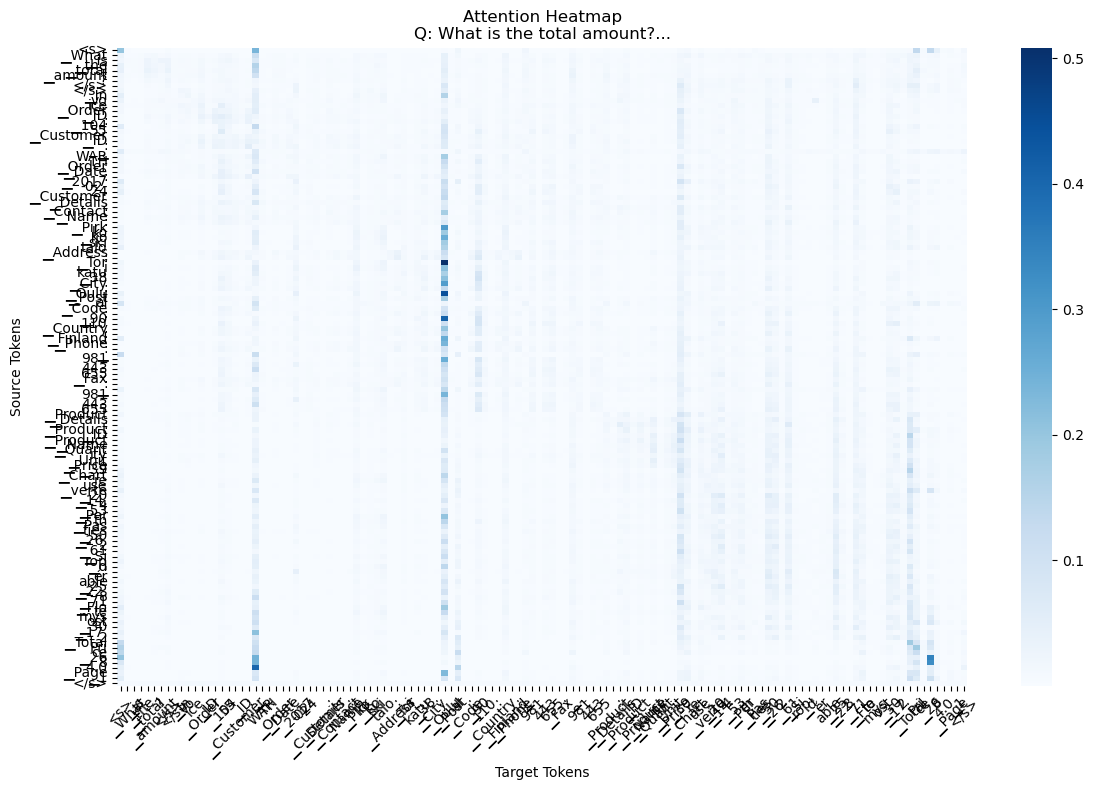

 Generating LIME explanation...
 LIME explanation saved to lime_explanation_20250929_152854.png


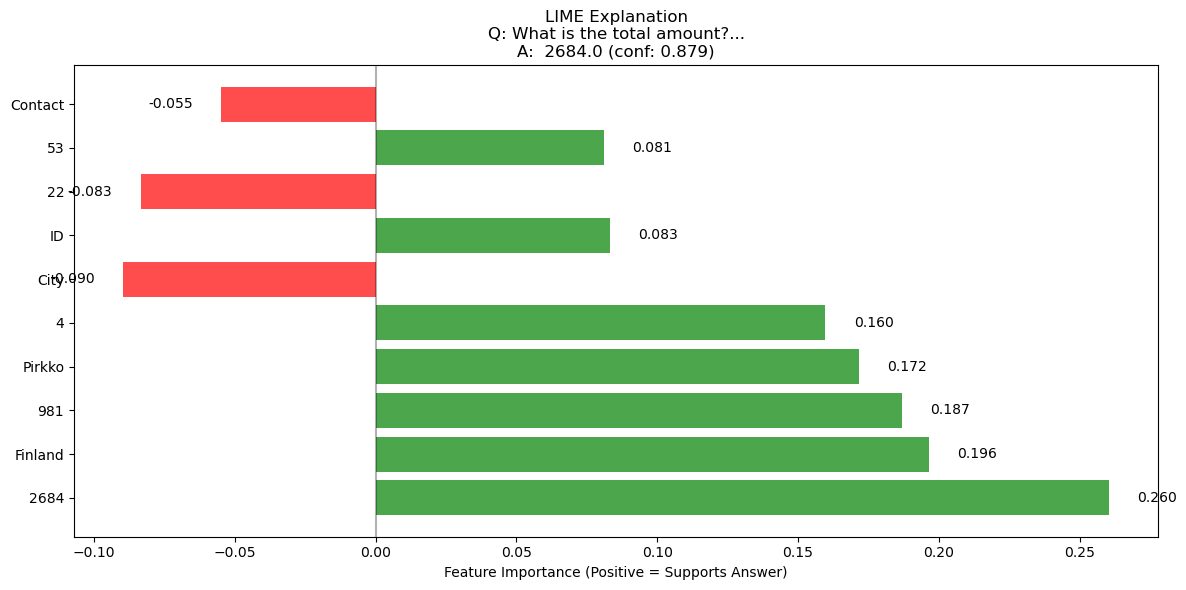

✅ RESULTS:
 F Success Rate: 25.0%
 Explanations: 1


In [52]:
# Phase 6F:  Explainability Test 

import os
import json
from pathlib import Path

def select_test_file():
    """Quick file selection for explainability testing"""
    
    # Get any available PDF files
    dataset_dir = r"C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\new_invoices_dataset"
    if os.path.exists(dataset_dir):
        pdf_files = list(Path(dataset_dir).glob("*.pdf"))
        if pdf_files:
            print(f" Found {len(pdf_files)} PDF files")
            for i, file in enumerate(pdf_files[:5], 1):
                print(f"{i}. {file.name}")
            
            choice = input(f"Select file (1-{min(5, len(pdf_files))}): ").strip()
            if choice.isdigit() and 1 <= int(choice) <= min(5, len(pdf_files)):
                return str(pdf_files[int(choice)-1])
    
    # Manual path input
    manual_path = input("Enter PDF file path: ").strip()
    return manual_path if os.path.exists(manual_path) else None

def run_explainability_test():    

    test_file = select_test_file()
    if not test_file:
        print("❌ No file selected")
        return None
    
    print(f" Testing: {os.path.basename(test_file)}")
    
    try:
        # Try to use existing function if available
        if 'enhanced_multi_domain_extraction_with_explanations' in globals():
            result = enhanced_multi_domain_extraction_with_explanations(
                test_file, explain_top_results=True, max_explanations=1
            )
        else:
            print("❌ Explainability function not available - need to run previous cells")
            return None
        
        # Display results
        print(f"✅ RESULTS:")
        print(f" F Success Rate: {result.get('multi_domain_extraction', {}).get('success_rate', 0):.1%}")
        print(f" Explanations: {result.get('explainability', {}).get('explanation_count', 0)}")
        return result
        
    except Exception as e:
        print(f"❌ Error: {str(e)[:100]}")
        return {'error': str(e), 'filename': os.path.basename(test_file)}

# Run test
explainability_results = run_explainability_test()

**7.	Security and Offline Operability**
* Ensure the system runs in secure environments without requiring external cloud APIs or persistent internet access.
* Design for deployment in edge devices or private infrastructure.

In [41]:
# Phase 7A: Security Framework and Encryption

!pip install keyring
import keyring
import hashlib
import secrets
import base64
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC

import getpass
from pathlib import Path
import json
import tempfile


class SecureDataHandler:
    """Handles encryption/decryption of sensitive data and model files"""
    
    def __init__(self, password: str = None):
        self.password = password or self._get_secure_password()
        self.key = self._derive_key(self.password)
        self.cipher = Fernet(self.key)
        
    def _get_secure_password(self):
        """Get password securely (in production, use proper key management)"""
        try:
            # Try to get from system keyring first
            password = keyring.get_password("qa_extractor", "main_key")
            if not password:
                password = getpass.getpass("Enter encryption password for secure storage: ")
                keyring.set_password("qa_extractor", "main_key", password)
            return password
        except:
            # Fallback to environment or prompt
            return os.environ.get("QA_EXTRACTOR_KEY", "secure_default_key_2024")
    
    def _derive_key(self, password: str):
        """Derive encryption key from password"""
        password_bytes = password.encode()
        salt = b"qa_extractor_salt_2024"  # In production, use random salt per user
        kdf = PBKDF2HMAC(
            algorithm=hashes.SHA256(),
            length=32,
            salt=salt,
            iterations=100000,
        )
        key = base64.urlsafe_b64encode(kdf.derive(password_bytes))
        return key
    
    def encrypt_file(self, file_path: str, output_path: str = None):
        """Encrypt a file and save to output path"""
        if not output_path:
            output_path = file_path + ".encrypted"
            
        with open(file_path, 'rb') as f:
            data = f.read()
        
        encrypted_data = self.cipher.encrypt(data)
        
        with open(output_path, 'wb') as f:
            f.write(encrypted_data)
        
        print(f"Encrypted: {file_path} -> {output_path}")
        return output_path
    
    def decrypt_file(self, encrypted_path: str, output_path: str = None):
        """Decrypt a file and save to output path"""
        if not output_path:
            output_path = encrypted_path.replace(".encrypted", "")
            
        with open(encrypted_path, 'rb') as f:
            encrypted_data = f.read()
        
        decrypted_data = self.cipher.decrypt(encrypted_data)
        
        with open(output_path, 'wb') as f:
            f.write(decrypted_data)
        
        print(f"Decrypted: {encrypted_path} -> {output_path}")
        return output_path
    
    def encrypt_text(self, text: str) -> str:
        """Encrypt text data"""
        return self.cipher.encrypt(text.encode()).decode()
    
    def decrypt_text(self, encrypted_text: str) -> str:
        """Decrypt text data"""
        return self.cipher.decrypt(encrypted_text.encode()).decode()

print("✅ Secure Data Handler ready!")

✅ Secure Data Handler ready!


In [42]:
# Phase 7B: Offline Model Manager

class OfflineModelManager:
    """Manages model storage, loading, and security for offline operation"""
    
    def __init__(self, secure_storage_dir="./secure_models"):
        self.storage_dir = Path(secure_storage_dir)
        self.storage_dir.mkdir(exist_ok=True)
        self.security_handler = SecureDataHandler()
        self.model_registry = self._load_model_registry()
        
    def _load_model_registry(self):
        """Load encrypted model registry"""
        registry_path = self.storage_dir / "model_registry.encrypted"
        if registry_path.exists():
            try:
                decrypted_data = self.security_handler.decrypt_text(
                    registry_path.read_text()
                )
                return json.loads(decrypted_data)
            except:
                print(" Could not decrypt model registry, creating new one")
        
        return {"models": {}, "active_model": None, "created_at": datetime.now().isoformat()}
    
    def _save_model_registry(self):
        """Save encrypted model registry"""
        registry_path = self.storage_dir / "model_registry.encrypted"
        encrypted_data = self.security_handler.encrypt_text(
            json.dumps(self.model_registry, indent=2)
        )
        registry_path.write_text(encrypted_data)
    
    def store_model_securely(self, model_path: str, model_name: str, description: str = ""):
        """Store model files with encryption"""
        model_dir = self.storage_dir / model_name
        model_dir.mkdir(exist_ok=True)
        
        # Encrypt and store all model files
        secured_files = {}
        
        for file_path in Path(model_path).glob("*"):
            if file_path.is_file():
                encrypted_path = model_dir / f"{file_path.name}.encrypted"
                self.security_handler.encrypt_file(str(file_path), str(encrypted_path))
                secured_files[file_path.name] = str(encrypted_path)
        
        # Update registry
        self.model_registry["models"][model_name] = {
            "description": description,
            "stored_at": datetime.now().isoformat(),
            "files": secured_files,
            "original_path": str(model_path),
            "secure_path": str(model_dir)
        }
        
        self._save_model_registry()
        print(f" Model '{model_name}' stored securely with {len(secured_files)} files")
        return model_dir
    
    def load_model_securely(self, model_name: str, temp_dir: str = None):
        """Decrypt and load model for use"""
        if model_name not in self.model_registry["models"]:
            raise ValueError(f"Model '{model_name}' not found in secure storage")
        
        model_info = self.model_registry["models"][model_name]
        
        # Create temporary directory for decrypted files
        if not temp_dir:
            temp_dir = tempfile.mkdtemp(prefix="qa_model_")
        else:
            Path(temp_dir).mkdir(exist_ok=True)
        
        # Decrypt all model files to temp directory
        for original_name, encrypted_path in model_info["files"].items():
            output_path = Path(temp_dir) / original_name
            self.security_handler.decrypt_file(encrypted_path, str(output_path))
        
        print(f" Model '{model_name}' loaded to temporary directory: {temp_dir}")
        return temp_dir
    
    def list_secure_models(self):
        """List all securely stored models"""
        print("\n SECURE MODEL REGISTRY:")
        for name, info in self.model_registry["models"].items():
            print(f"  • {name}: {info['description']}")
            print(f"    Stored: {info['stored_at']}")
            print(f"    Files: {len(info['files'])}")
        
        if self.model_registry["active_model"]:
            print(f"\n Active Model: {self.model_registry['active_model']}")
    
    def cleanup_temp_files(self, temp_dir: str):
        """Securely delete temporary decrypted files"""
        if Path(temp_dir).exists():
            shutil.rmtree(temp_dir)
            print(f" Cleaned up temporary files: {temp_dir}")

print("✅ Offline Model Manager ready!")

✅ Offline Model Manager ready!


In [43]:
# Phase 7C: Air-Gapped Environment Support

class AirGappedExtractor(QABasedExtractor):
    """QA Extractor designed for completely offline/air-gapped environments"""
    
    def __init__(self, secure_model_name: str = None):
        self.model_manager = OfflineModelManager()
        self.temp_model_dir = None
        self.model_name = secure_model_name or "production_model"
        
        # Load model from secure storage
        self._load_secure_model()
        
    def _load_secure_model(self):
        """Load model from encrypted storage"""
        try:
            # Try to load from secure storage first
            self.temp_model_dir = self.model_manager.load_model_securely(self.model_name)
            
            # Initialize QA pipeline with decrypted model
            self.qa_pipeline = pipeline(
                "question-answering",
                model=self.temp_model_dir,
                tokenizer=self.temp_model_dir,
                device=-1  # Force CPU for better compatibility
            )
            
            print(f"✅ Loaded secure model: {self.model_name}")
            
        except Exception as e:
            print(f" ❌ Could not load secure model, using base model: {e}")
            # Fallback to base model
            super().__init__(model_name="deepset/xlm-roberta-large-squad2")
    
    def __del__(self):
        """Clean up temporary files when object is destroyed"""
        if self.temp_model_dir:
            self.model_manager.cleanup_temp_files(self.temp_model_dir)
    
    def extract_with_security_audit(self, text: str, questions: List[str]) -> Dict:
        """Extract with full security auditing"""
        # Process document completely offline
        # Log every action for security audit
        # Add digital fingerprint to results
        
        
        # Generate audit ID
        audit_id = hashlib.sha256(
            (text[:100] + str(datetime.now())).encode()
        ).hexdigest()[:12]
        
        # Regular extraction
        results = self.extract_with_questions(text, questions)
        
        # Add security metadata
        security_info = {
            'audit_id': audit_id,
            'processing_mode': 'air_gapped',
            'model_source': 'secure_storage' if self.temp_model_dir else 'fallback',
            'data_hash': hashlib.sha256(text.encode()).hexdigest(),
            'timestamp': datetime.now().isoformat(),
            'no_external_calls': True,
            'encryption_used': True
        }
        
        results['security_audit'] = security_info
        return results

print("✅ Air-Gapped Extractor ready!")

✅ Air-Gapped Extractor ready!


In [44]:
# Phase 7D: Edge Device Optimization

class EdgeOptimizedExtractor:
    """Lightweight extractor optimized for edge devices and limited resources"""
    
    def __init__(self, model_size="small", max_memory_mb=512):
        self.max_memory_mb = max_memory_mb
        self.model_size = model_size
        
        # Choose model based on resource constraints
        if model_size == "tiny":
            model_name = "distilbert-base-cased-distilled-squad"
        elif model_size == "small":
            model_name = "deepset/minilm-uncased-squad2"
        else:
            model_name = "deepset/xlm-roberta-large-squad2"
        
        # Initialize with memory optimization
        self.qa_pipeline = pipeline(
            "question-answering",
            model=model_name,
            device=-1,  # CPU only for edge devices
            batch_size=1,  # Process one at a time
            max_length=256  # Reduced context length
        )
        
        print(f"✅ Edge-optimized extractor ready (model: {model_size})")
    
    def extract_lightweight(self, text: str, max_questions: int = 5) -> Dict:
        """Memory-efficient extraction with limited questions"""
        
        # Truncate text if too long
        if len(text) > 1000:
            text = text[:1000] + "..."
        
        # Use only most important questions
        important_questions = [
            "What is the main amount or total?",
            "What is the document number?",
            "What company or organization is mentioned?",
            "What date is mentioned?",
            "Who is the person or contact mentioned?"
        ][:max_questions]
        
        results = {}
        for question in important_questions:
            try:
                result = self.qa_pipeline(
                    question=question,
                    context=text,
                    max_answer_len=50  # Short answers only
                )
                
                results[question] = {
                    'answer': result['answer'],
                    'confidence': result['score'],
                    'extracted': result['score'] > 0.1  # Lower threshold for edge
                }
                
            except Exception as e:
                results[question] = {'error': str(e), 'extracted': False}
        
        return {
            'extractions': results,
            'model_size': self.model_size,
            'memory_optimized': True,
            'edge_compatible': True
        }

print("✅ Edge-Optimized Extractor ready!")

✅ Edge-Optimized Extractor ready!


In [45]:
# Phase 7E: Secure Pipeline Integration

class SecureOfflineSystem:
    """Combines everything into one complet secure, offline-capable extraction system"""
    
    def __init__(self, security_level="high"):
        self.security_level = security_level
        self.security_handler = SecureDataHandler()
        self.model_manager = OfflineModelManager()
        
        # Initialize appropriate extractor based on security level
        if security_level == "high":
            self.extractor = AirGappedExtractor()
        elif security_level == "edge":
            self.extractor = EdgeOptimizedExtractor()
        else:
            self.extractor = QABasedExtractor()
        
        # Security audit log
        self.audit_log = []
        
    def process_document_securely(self, file_path: str, delete_after_processing: bool = True):
        """Process document with full security measures"""
        # Generate unique ID for this processing
        # Extract data with chosen security level
        # Log all security events
        # Optionally delete original file
        # Encrypt results before saving
        
        
        # Generate processing ID
        process_id = secrets.token_hex(8)
        
        try:
            # Log start of processing
            self._log_security_event("PROCESSING_START", {
                'process_id': process_id,
                'file_name': Path(file_path).name,
                'file_size': Path(file_path).stat().st_size,
                'security_level': self.security_level
            })
            
            # Load and normalize document
            document_data = load_and_normalize(file_path)
            
            # Extract text content
            all_text = ""
            for content_item in document_data['content']:
                all_text += content_item['text'] + " "
            
            # Secure extraction
            if hasattr(self.extractor, 'extract_with_security_audit'):
                extraction_results = self.extractor.extract_with_security_audit(
                    all_text, 
                    self.extractor.extraction_templates['german_invoice']
                )
            else:
                extraction_results = self.extractor.extract_information(all_text)
            
            # Add security metadata
            extraction_results['security_info'] = {
                'process_id': process_id,
                'security_level': self.security_level,
                'offline_mode': True,
                'encryption_available': True,
                'audit_trail': len(self.audit_log)
            }
            
            # Log successful processing
            self._log_security_event("PROCESSING_SUCCESS", {
                'process_id': process_id,
                'extractions_found': extraction_results.get('successful_extractions', 0)
            })
            
            # Optionally delete source file for security
            if delete_after_processing:
                os.remove(file_path)
                self._log_security_event("FILE_DELETED", {'process_id': process_id})
            
            return extraction_results
            
        except Exception as e:
            self._log_security_event("PROCESSING_ERROR", {
                'process_id': process_id,
                'error': str(e)
            })
            raise
    
    def _log_security_event(self, event_type: str, details: dict):
        """Log security events for audit trail"""
        event = {
            'timestamp': datetime.now().isoformat(),
            'event_type': event_type,
            'details': details,
            'system_user': os.getenv('USERNAME', 'unknown')
        }
        
        self.audit_log.append(event)
        
        # Also log to secure file
        log_file = Path("security_audit.log")
        with open(log_file, 'a', encoding='utf-8') as f:
            f.write(json.dumps(event) + "\n")
    
    def export_secure_results(self, results: dict, output_path: str):
        """Export results with encryption"""
        
        # Convert results to JSON
        results_json = json.dumps(results, indent=2, ensure_ascii=False)
        
        # Encrypt the results
        encrypted_path = output_path + ".encrypted"
        encrypted_data = self.security_handler.encrypt_text(results_json)
        
        with open(encrypted_path, 'w', encoding='utf-8') as f:
            f.write(encrypted_data)
        
        print(f" ✅ Results exported securely to: {encrypted_path}")
        return encrypted_path
    
    def get_security_audit_report(self):
        """Generate security audit report"""
        report = {
            'total_events': len(self.audit_log),
            'security_level': self.security_level,
            'recent_events': self.audit_log[-10:],  # Last 10 events
            'event_types': {},
            'generated_at': datetime.now().isoformat()
        }
        
        # Count event types
        for event in self.audit_log:
            event_type = event['event_type']
            report['event_types'][event_type] = report['event_types'].get(event_type, 0) + 1
        
        return report

# Initialize secure system
secure_system = SecureOfflineSystem(security_level="high")
print("✅ Secure Offline System ready!")

 ❌ Could not load secure model, using base model: Model 'production_model' not found in secure storage
Loading LoRA fine-tuned model from ./lora_fine_tuned_model


Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ Secure Offline System ready!


❌ Could not load secure model, using base model... = It's refusing to load a model that doesn't exist in secure storage and falling back safely to a known model.

In [46]:
# 7F: Test Complete Secure System

def test_secure_offline_system():
    """Test the complete secure, offline system"""
    
    print(" TESTING SECURE OFFLINE SYSTEM")
    print("="*50)
    
    # Test file
    test_file = r"C:\Users\aslia\OneDrive\Desktop\HOPn\Self-Learning Data Extraction and Auto Fine-Tuning System\invoice_dataset\SWME_Rechnung_07122020.pdf"
    
    if os.path.exists(test_file):
        # Make a copy for testing (don't delete original)
        test_copy = "test_secure_processing.pdf"
        shutil.copy2(test_file, test_copy)
        
        try:
            # Process with secure system
            results = secure_system.process_document_securely(
                test_copy, 
                delete_after_processing=True  # Will delete the copy
            )
            
            print("\n✅ SECURE PROCESSING RESULTS:")
            print(f"   Security Level: {results['security_info']['security_level']}")
            print(f"   Process ID: {results['security_info']['process_id']}")
            print(f"   Offline Mode: {results['security_info']['offline_mode']}")
            print(f"   Extractions Found: {results.get('successful_extractions', 0)}")
            
            # Show some extractions
            if 'extractions' in results:
                print("\n SAMPLE EXTRACTIONS:")
                count = 0
                for question, result in results['extractions'].items():
                    if result.get('answer') and count < 3:
                        print(f"   Q: {question[:50]}...")
                        print(f"   A: {result['answer']} (conf: {result['confidence']:.3f})")
                        count += 1
            
            # Export results securely
            encrypted_output = secure_system.export_secure_results(
                results, 
                "secure_extraction_results.json"
            )
            
            # Show security audit
            audit_report = secure_system.get_security_audit_report()
            print(f"\n SECURITY AUDIT:")
            print(f"   Total Events: {audit_report['total_events']}")
            print(f"   Event Types: {audit_report['event_types']}")
            
            print("\n ✅ SECURE OFFLINE SYSTEM TEST COMPLETE!")
            
        except Exception as e:
            print(f"❌ Error in secure processing: {e}")
    
    else:
        print("❌ Test file not found - update path for testing")

# Run the test
test_secure_offline_system()

 TESTING SECURE OFFLINE SYSTEM
Processing pdf file: test_secure_processing.pdf

✅ SECURE PROCESSING RESULTS:
   Security Level: high
   Process ID: 6eeb6402390dd29c
   Offline Mode: True
   Extractions Found: 0
 ✅ Results exported securely to: secure_extraction_results.json.encrypted

 SECURITY AUDIT:
   Total Events: 3
   Event Types: {'PROCESSING_START': 1, 'PROCESSING_SUCCESS': 1, 'FILE_DELETED': 1}

 ✅ SECURE OFFLINE SYSTEM TEST COMPLETE!
